In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D


from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter

plt.style.use("/Users/linsi/Documents/stanford/pythonstyle/evanstyle.mplstyle")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'

#import the folder that has the analysis level class
sys.path.append("/Users/linsi/Documents/stanford/HV/ad2-data-processing/CombinedData/")
sys.path.append("/Users/linsi/Documents/stanford/HV/ad2-data-processing/AnalysisTools/")
import Dataset
import AnalysisTools

In [2]:
topdirs = {5:"/Users/linsi/Documents/stanford/HV/data/Run5/", 6:"/Users/linsi/Documents/stanford/HV/data/Run6/", 7:"/Users/linsi/Documents/stanford/HV/data/Run7/", 8:"/Users/linsi/Documents/stanford/HV/data/Run8/", 9:"/Users/linsi/Documents/stanford/HV/data/Run9/"}
configs = {5:"/Users/linsi/Documents/stanford/HV/ad2-data-processing/configs/run5_config.yaml", 6:"/Users/linsi/Documents/stanford/HV/ad2-data-processing/configs/run6_config.yaml", 7:"/Users/linsi/Documents/stanford/HV/ad2-data-processing/configs/run7_config.yaml", 8:"/Users/linsi/Documents/stanford/HV/ad2-data-processing/configs/run8_config.yaml", 9:"/Users/linsi/Documents/stanford/HV/ad2-data-processing/configs/run9_config.yaml"}
titles = {5:"SS uncoated", 6:"Refill of SS uncoated", 7:"MgF2 (50nm)", 8:"Pt (50nm)", 9:"MgF2 (20nm)"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    if(n == 6):continue
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])

/Users/linsi/Documents/stanford/HV/ad2-data-processing/AnalysisTools/AnalysisTools.py:127: UserWarning: genfromtxt: Empty input file: "/Users/linsi/Documents/stanford/HV/data/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


In [3]:
#load data into mem if you want
for n, ana in anas.items():
    if(n == 6): continue
    ana.load_dataframe()

In [4]:
ana = anas[9]
d = ana.df
d = d[~d["ch3 charge"].isna()]
#select charge event mask for which to qualify coincidences with
mask = (d["ch3 n negpeaks"] > 0) & (d["ch3 n pospeaks"] == 0) & (np.abs(d["ch3 charge"]) > 1)
#mask = (d["ch3 n pospeaks"] > 0) & (np.abs(d["ch3 charge"]) > 1) #looking at positive polar events

d = d[mask]

#coincidence info
time_ref_ch = 3 #software channel for which to look for coincidences of
coinc = 10 #long coincidence window in seconds, sets the length of a movie observing these events. 

coinc_ns = 0
event_dfs = ana.get_coincidence(d, time_ref_ch, coinc, coinc_ns)


19.98325379200001


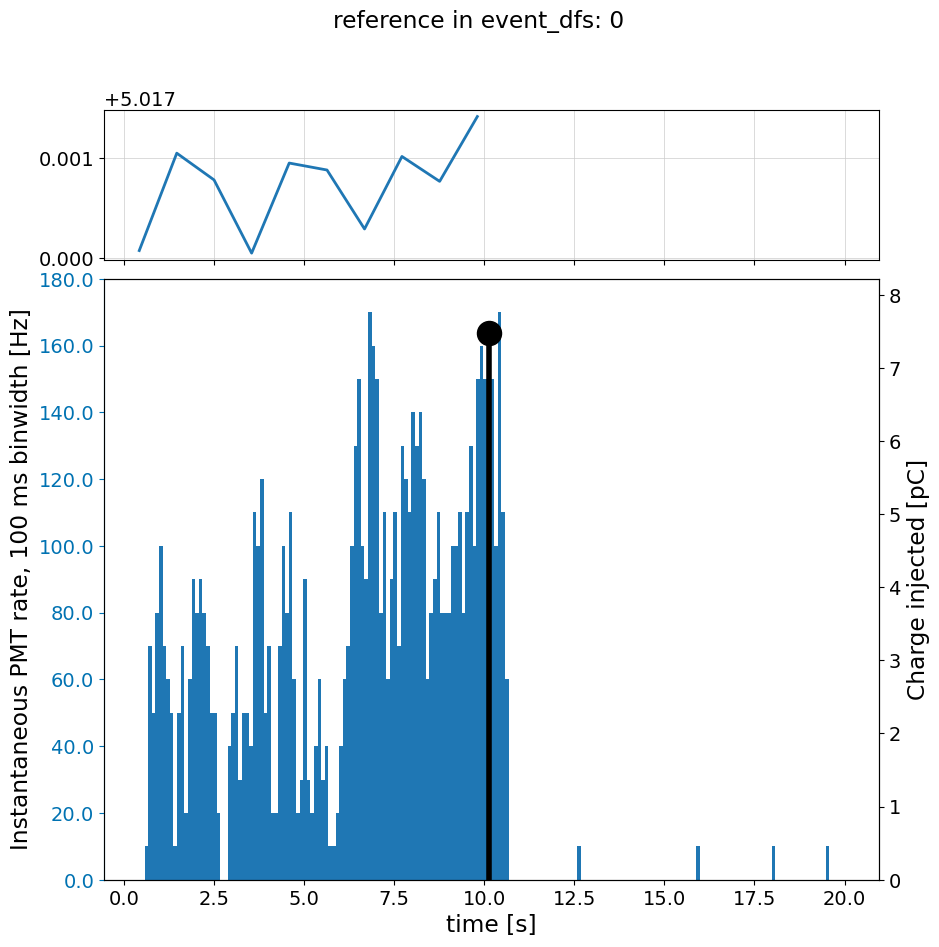

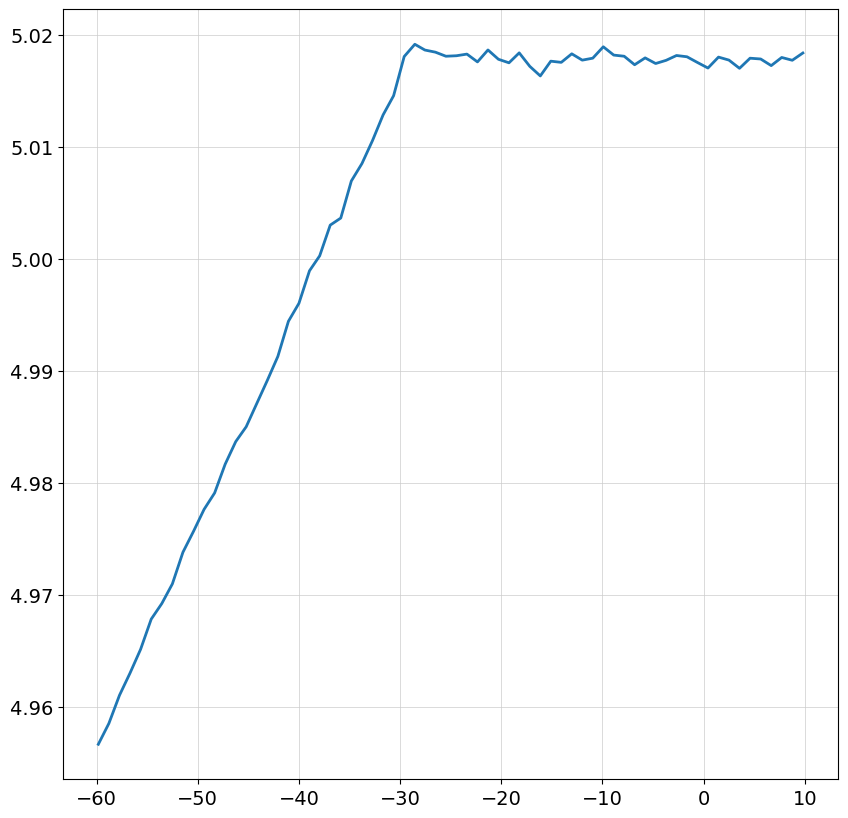

19.658166712000025


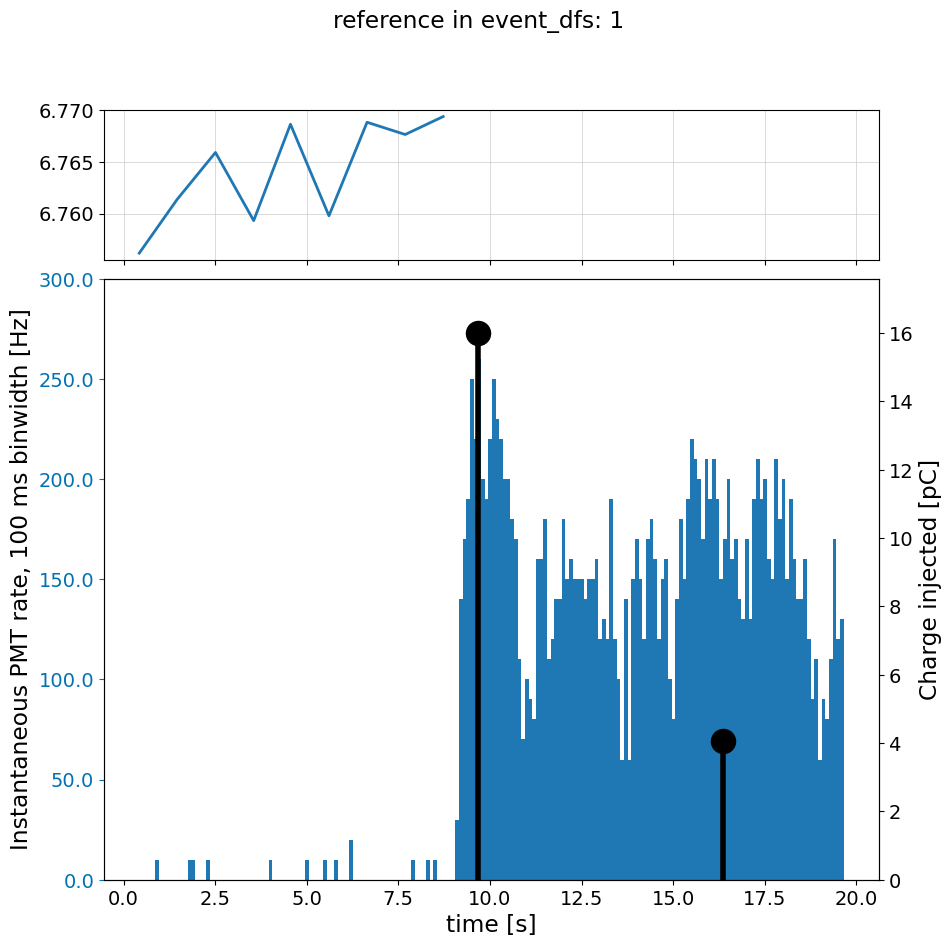

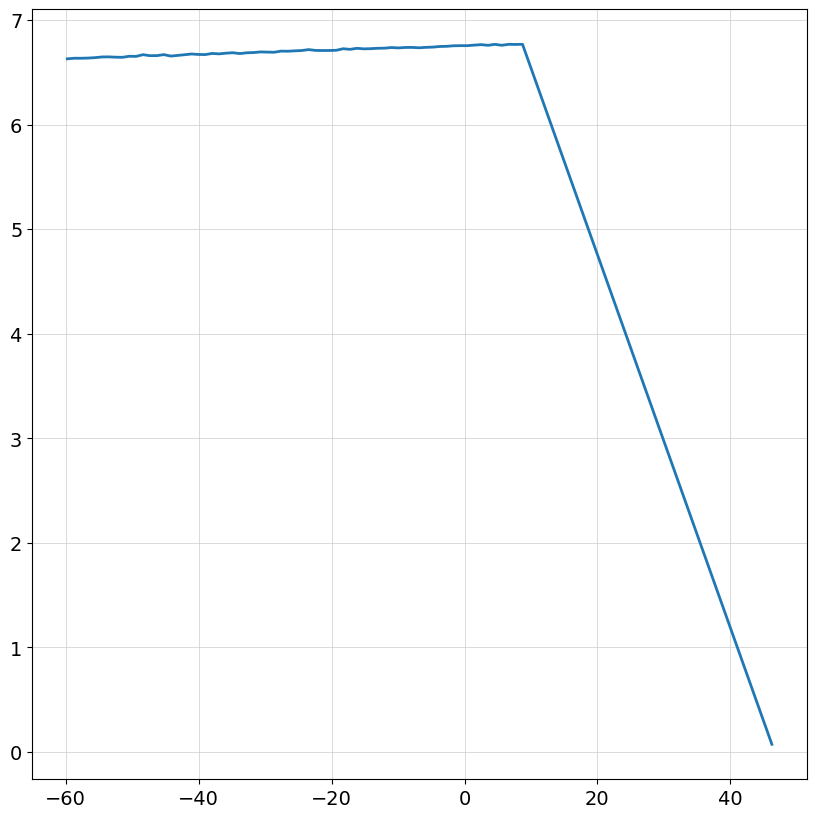

18.538031152000094


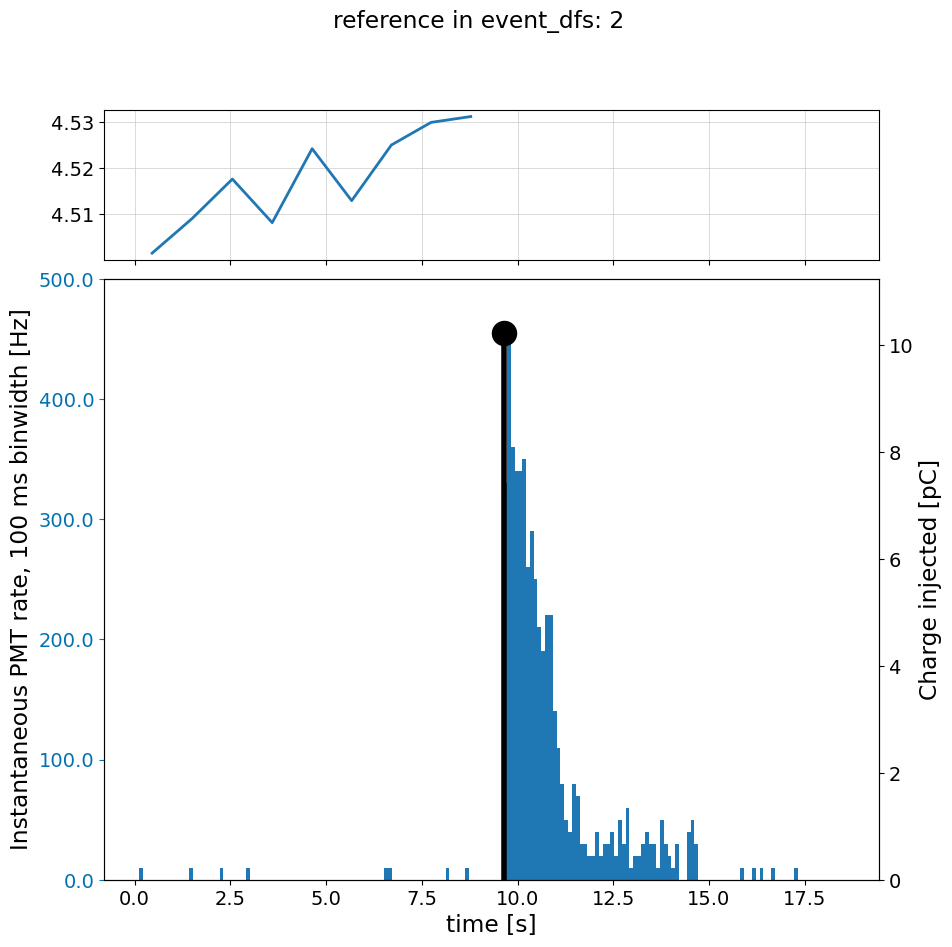

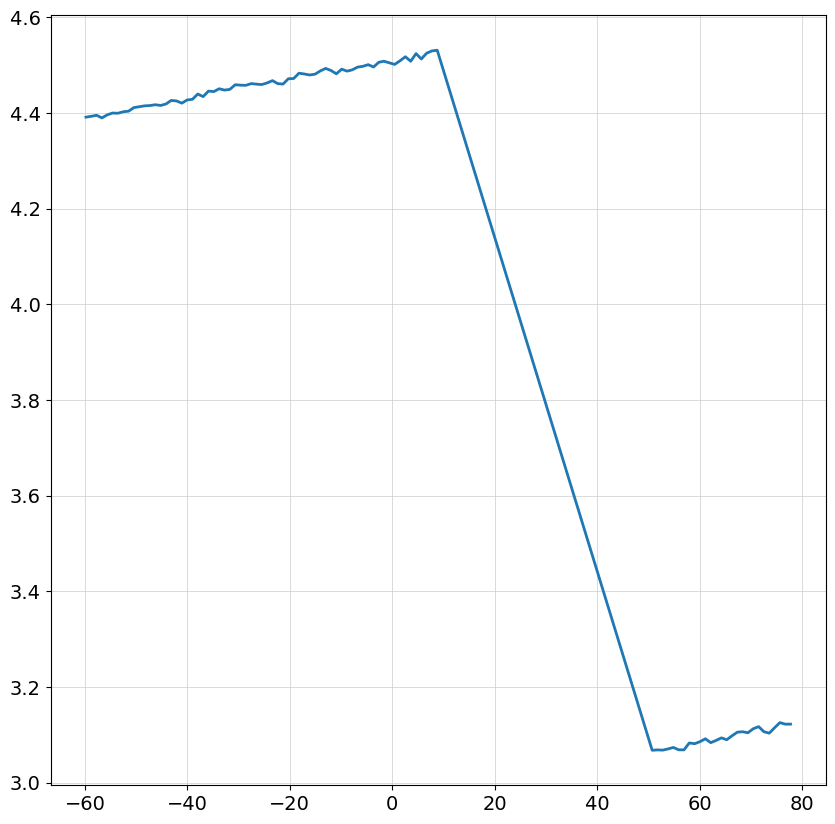

19.309669160000027


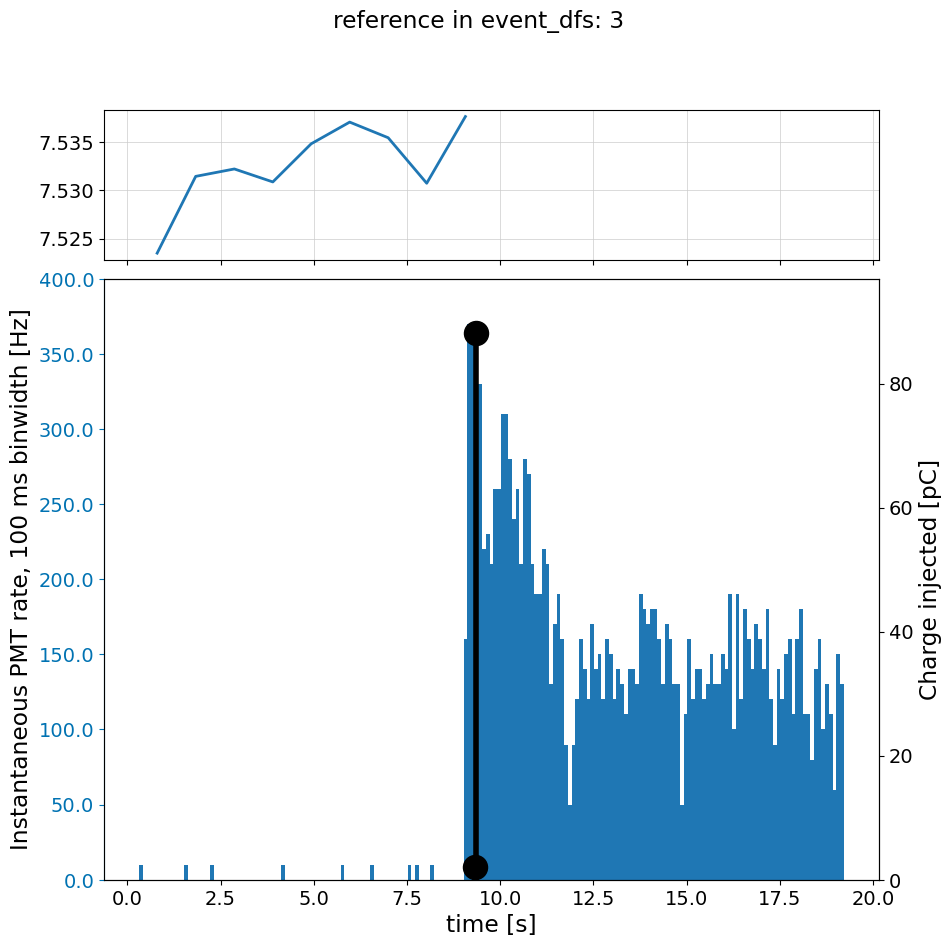

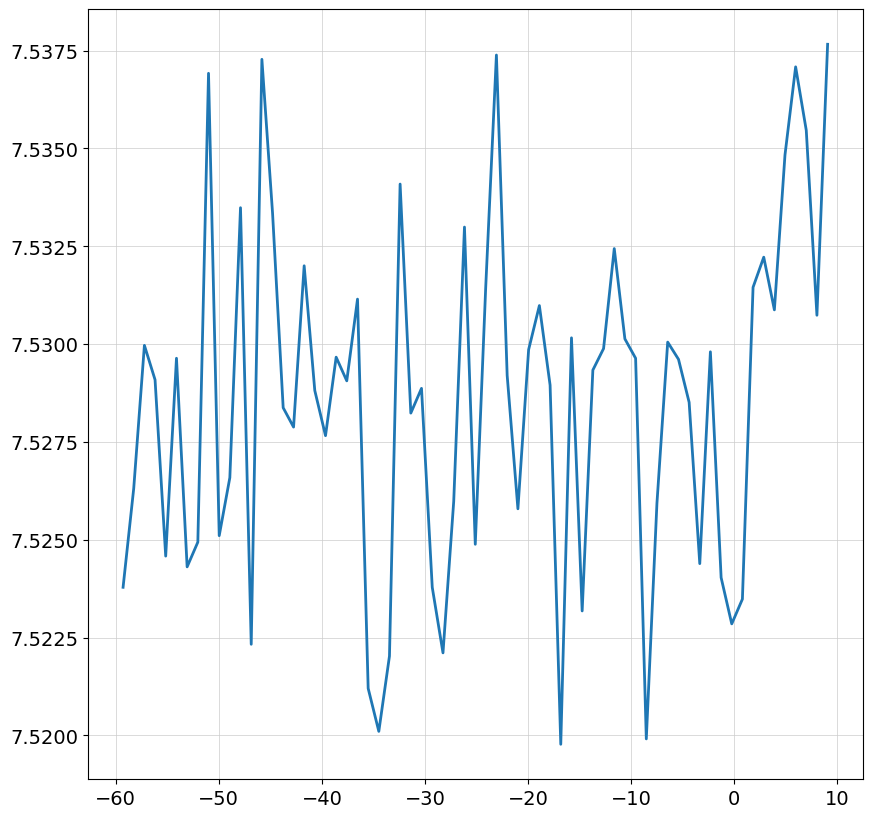

17.350945336000102


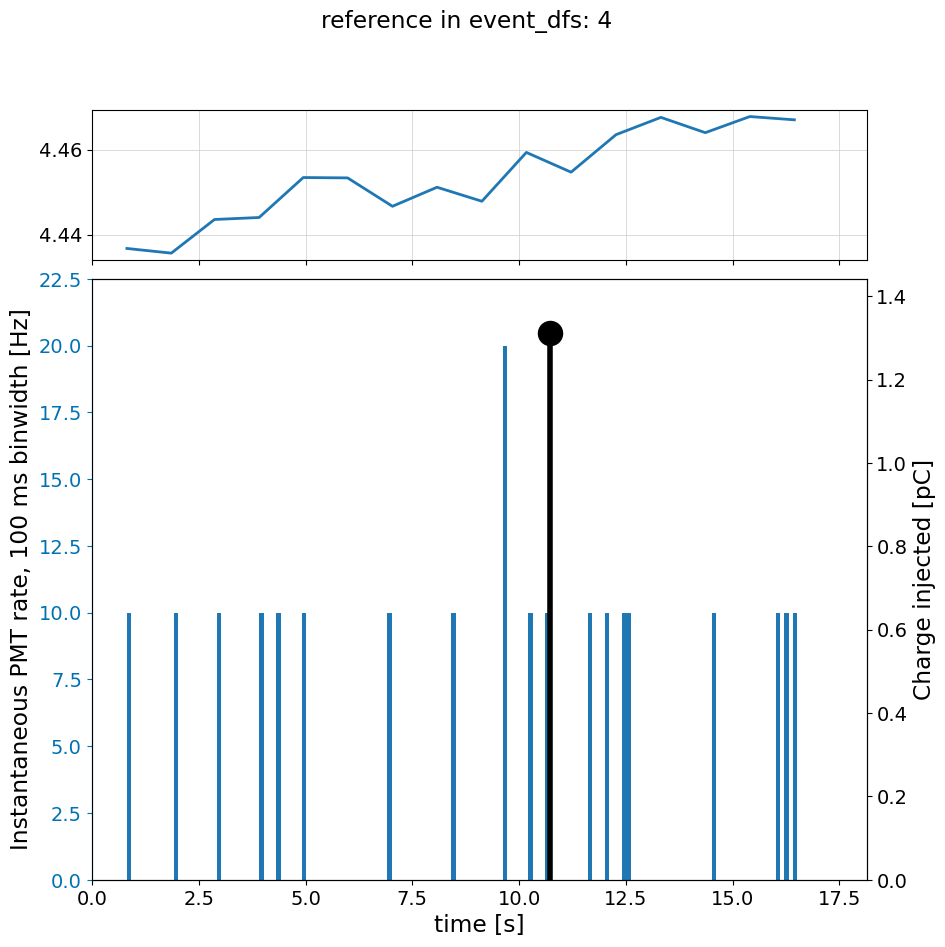

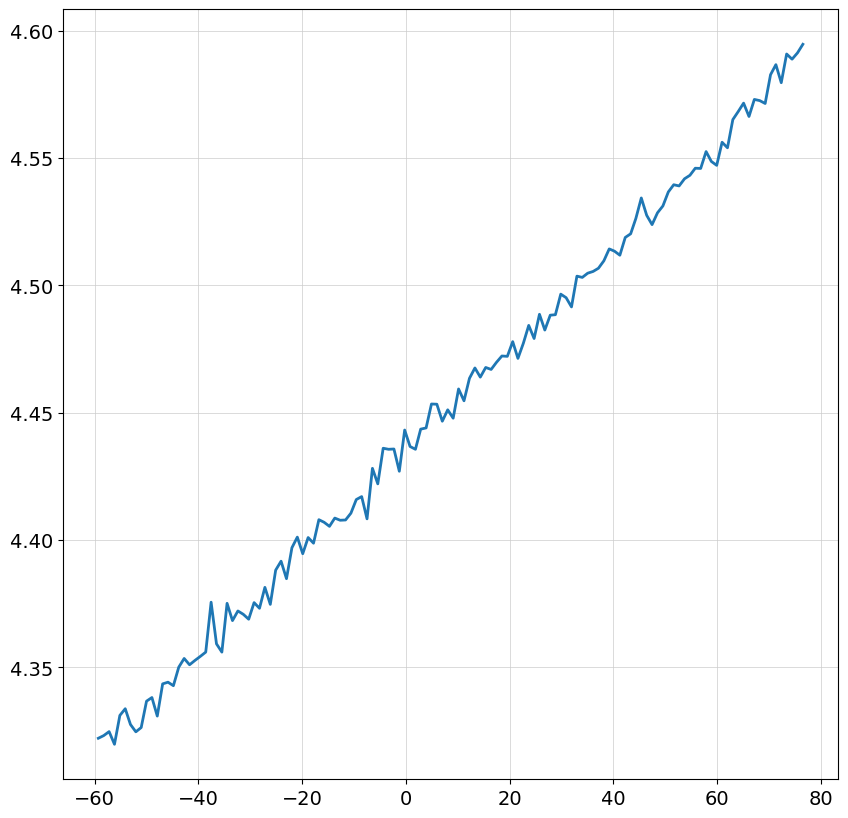

15.742008400000099


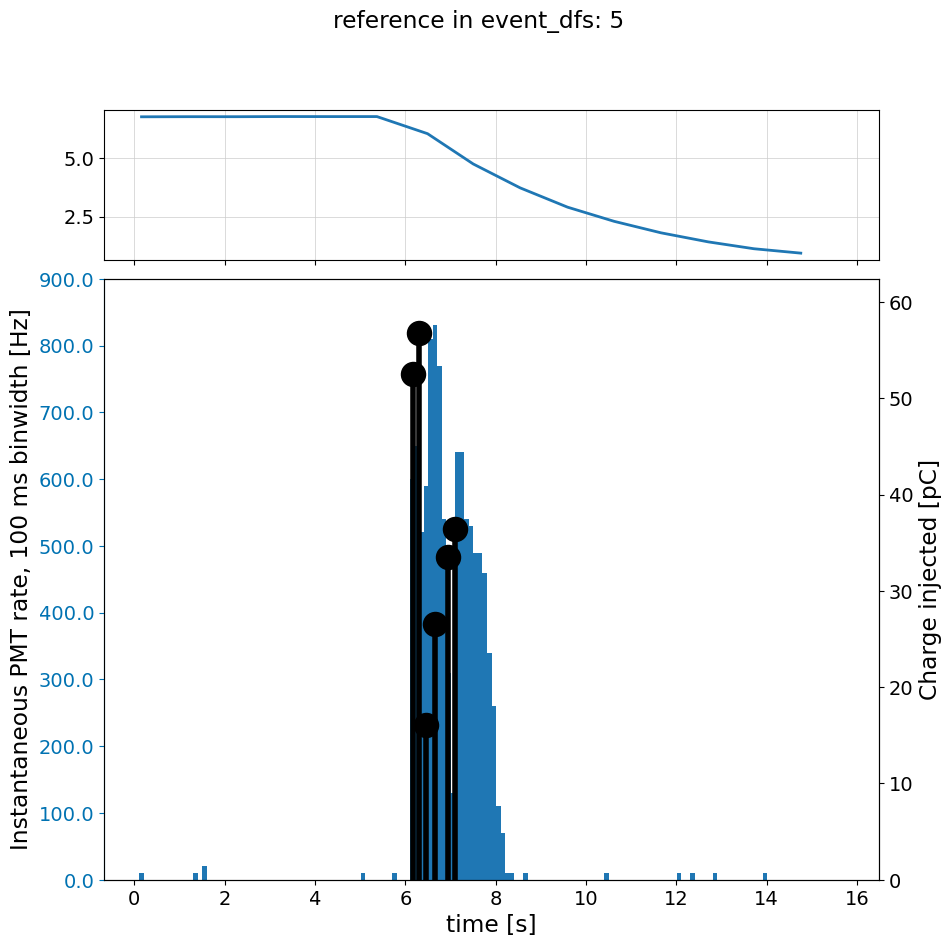

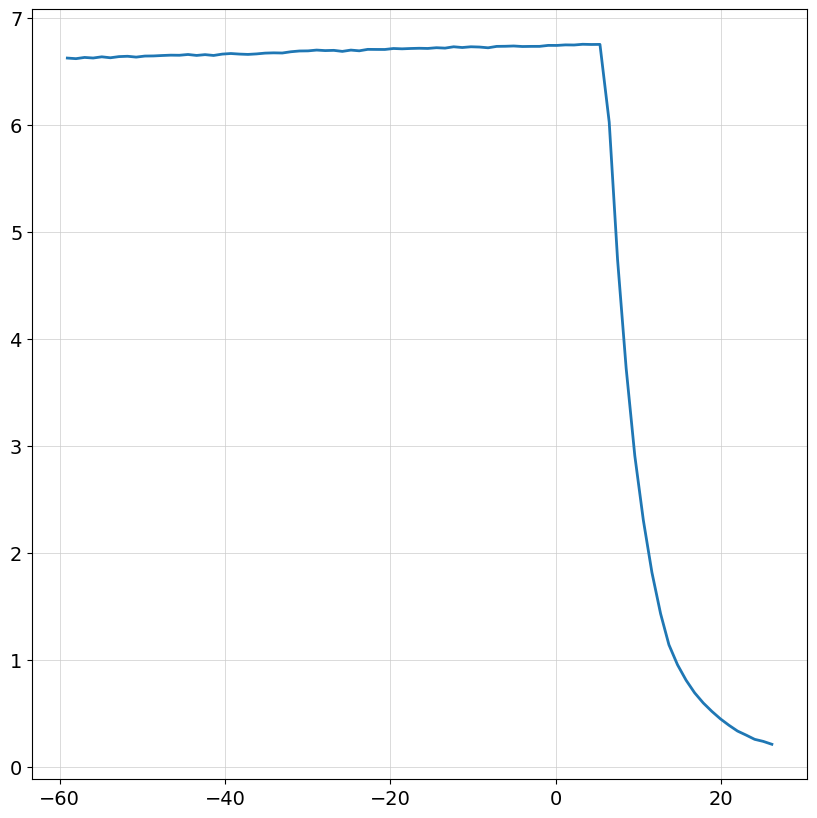

12.667989944000018


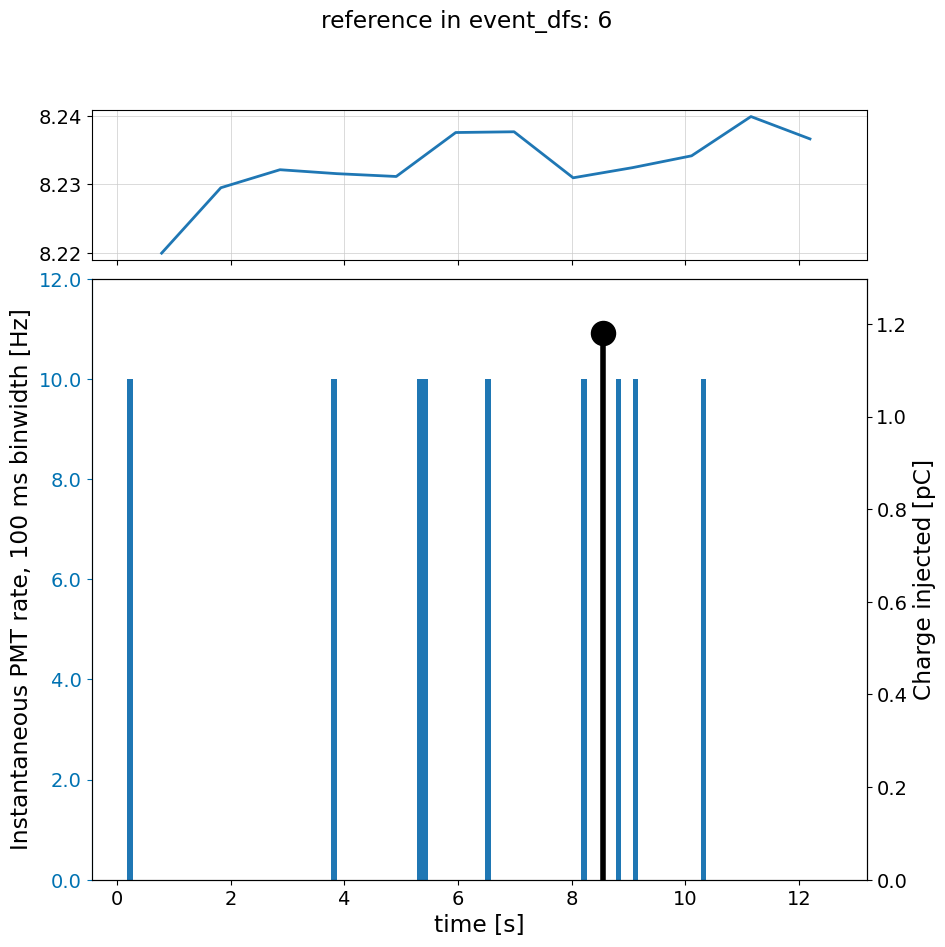

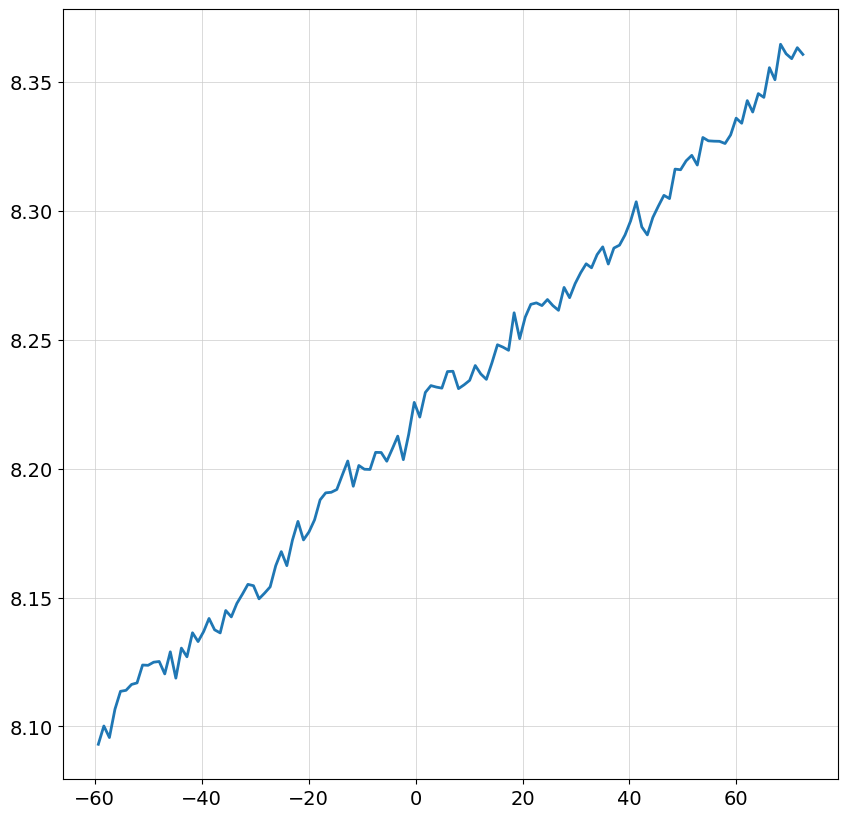

14.249387696000005


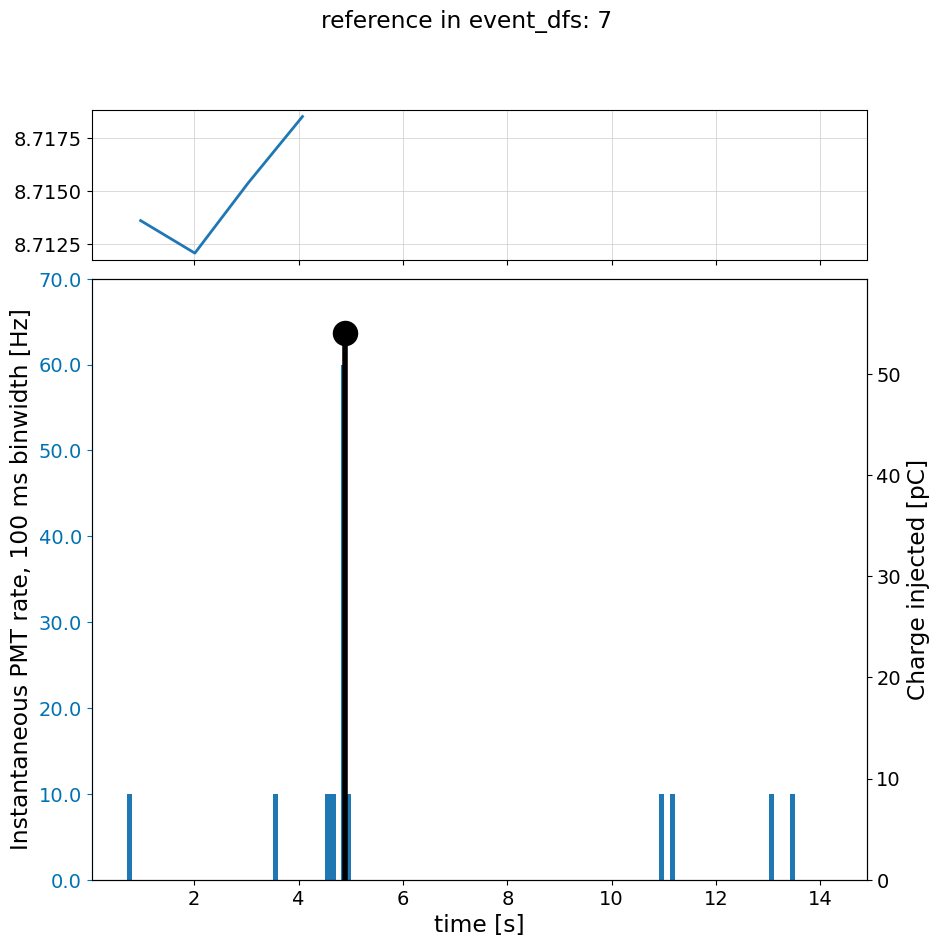

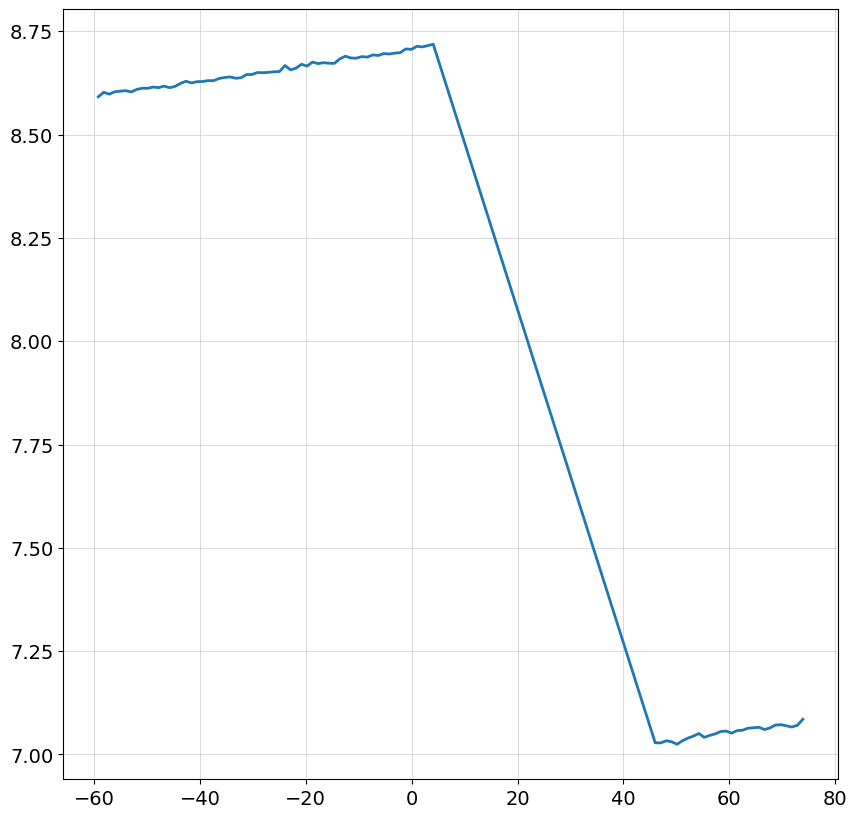

18.39729722400002


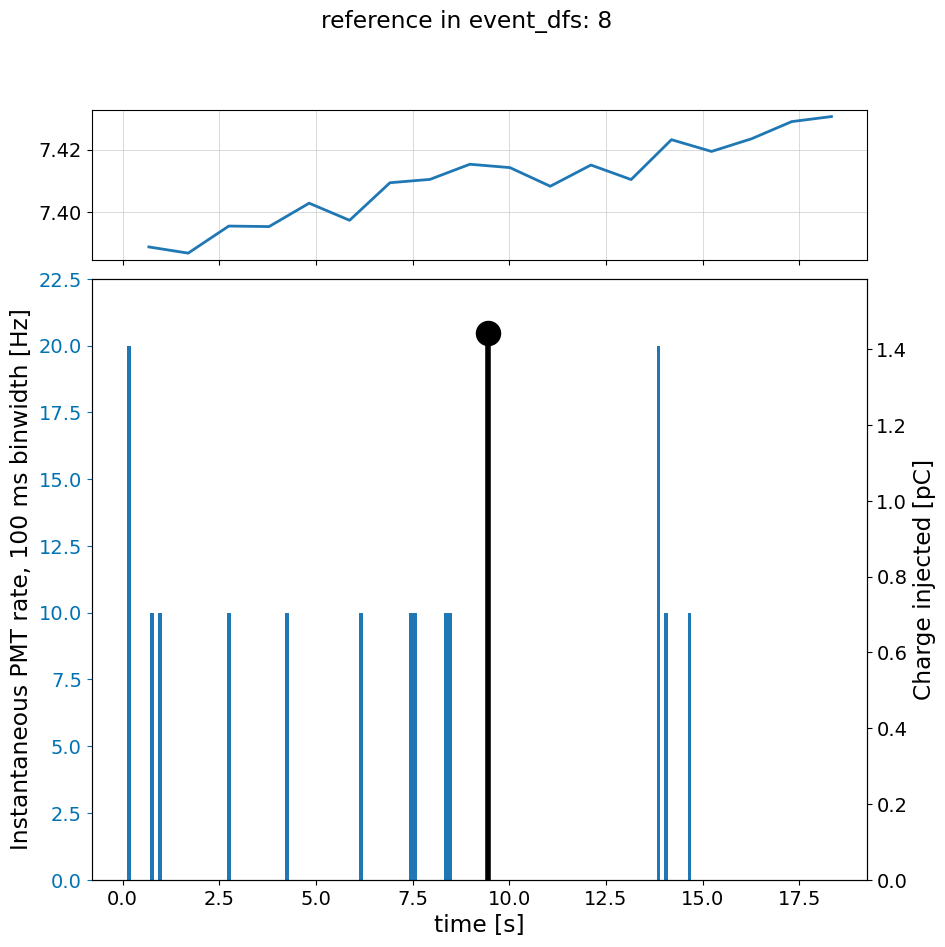

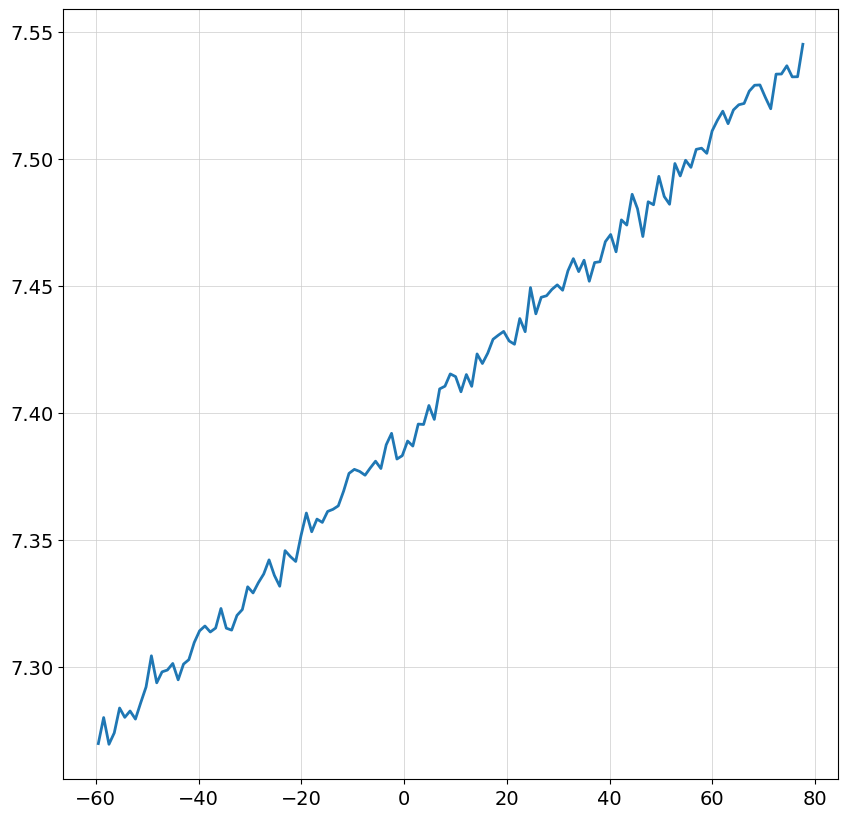

18.266785832000004


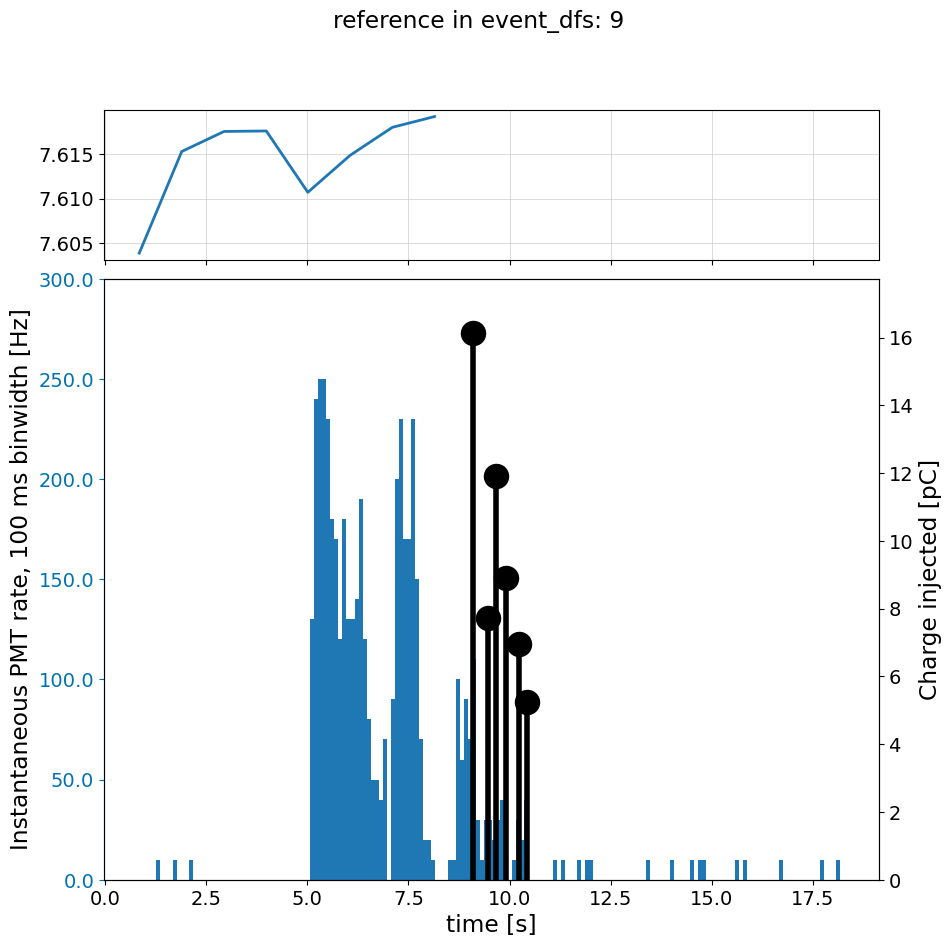

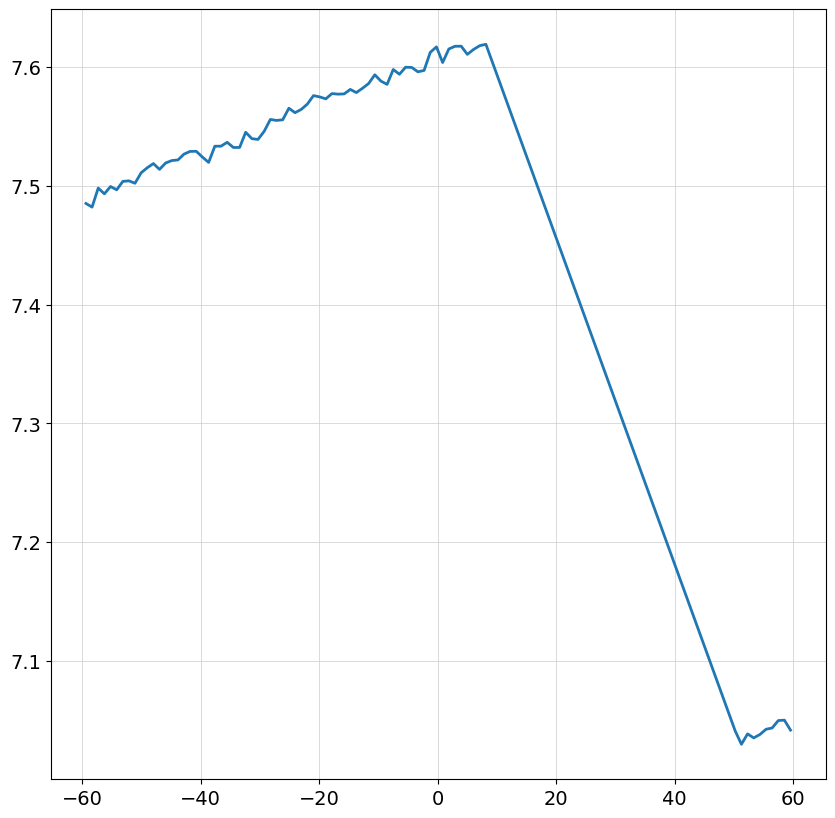

17.720589512000025


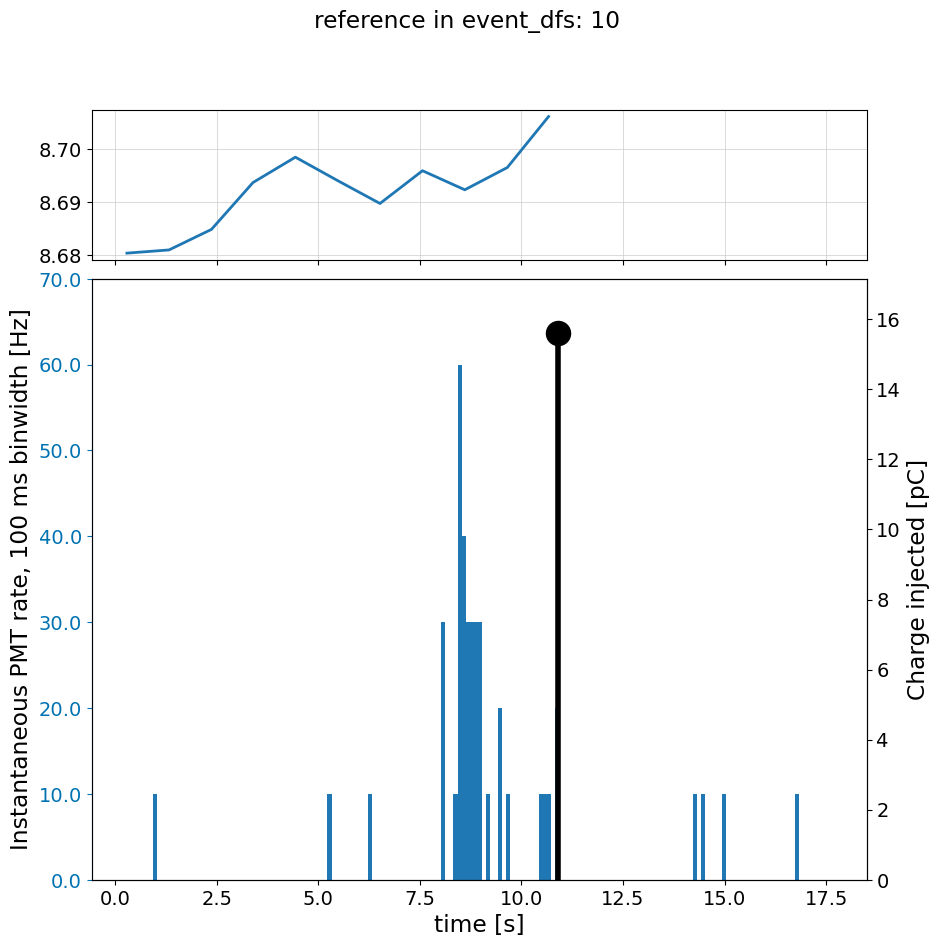

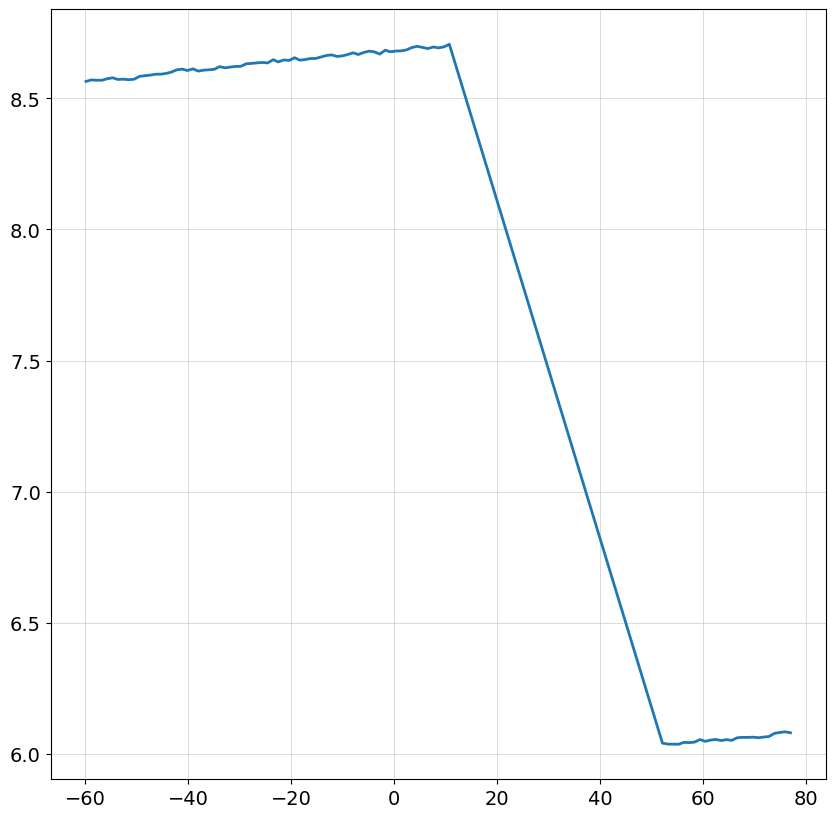

19.014666920000057


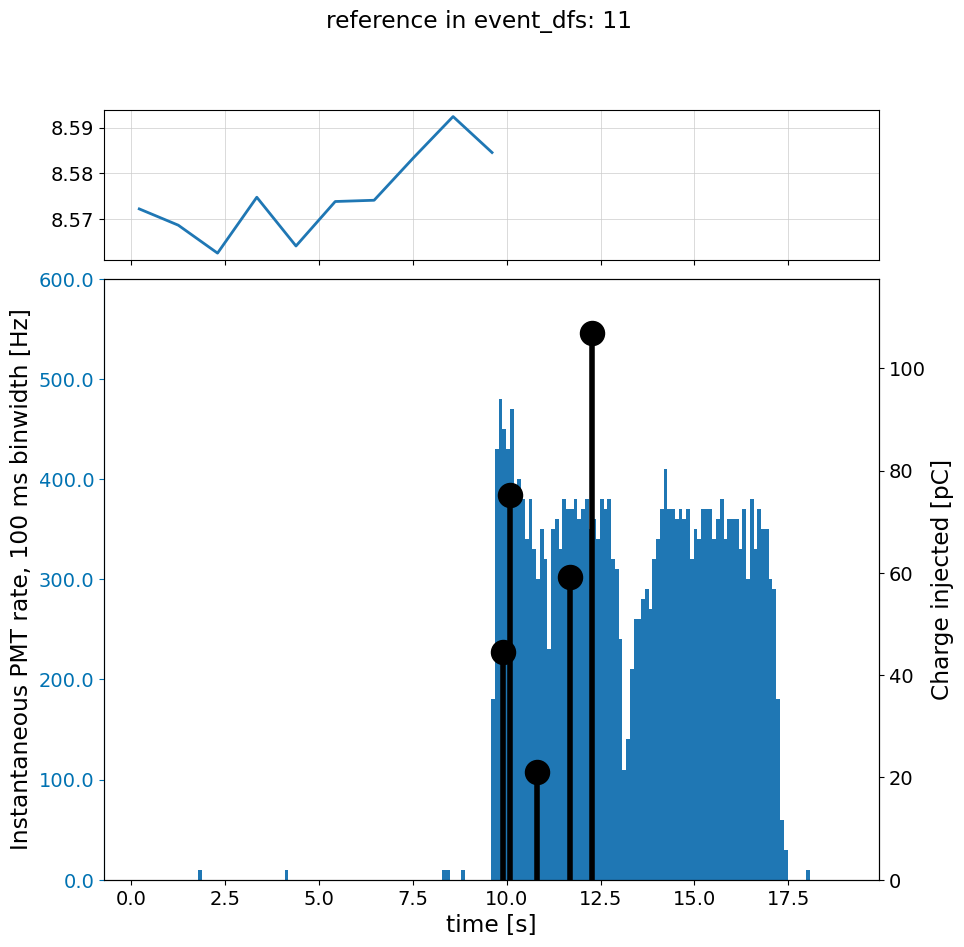

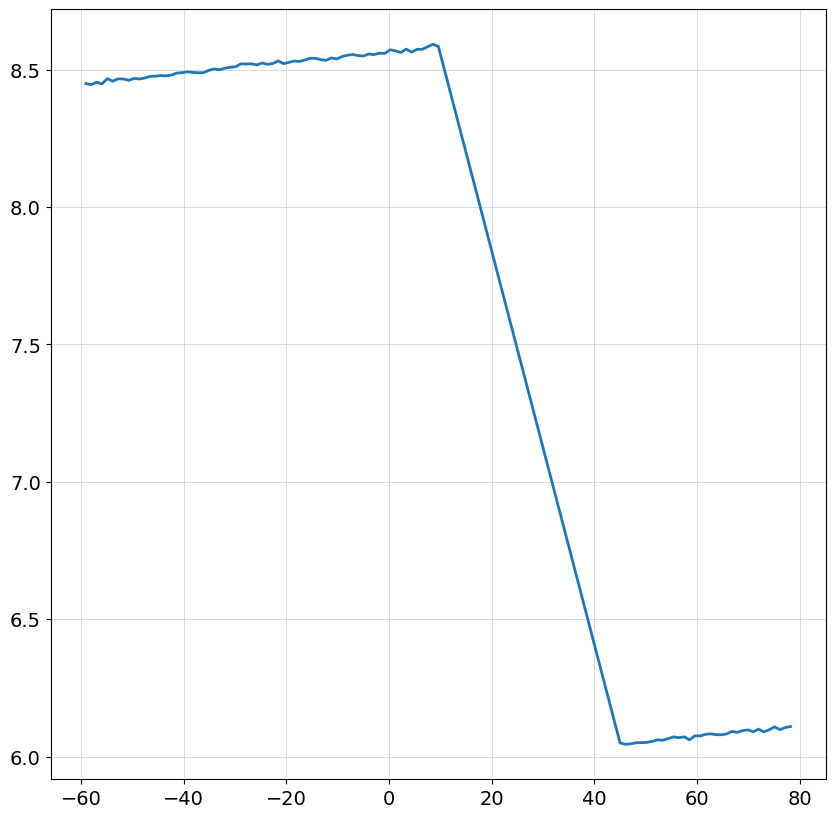

19.17956292800001


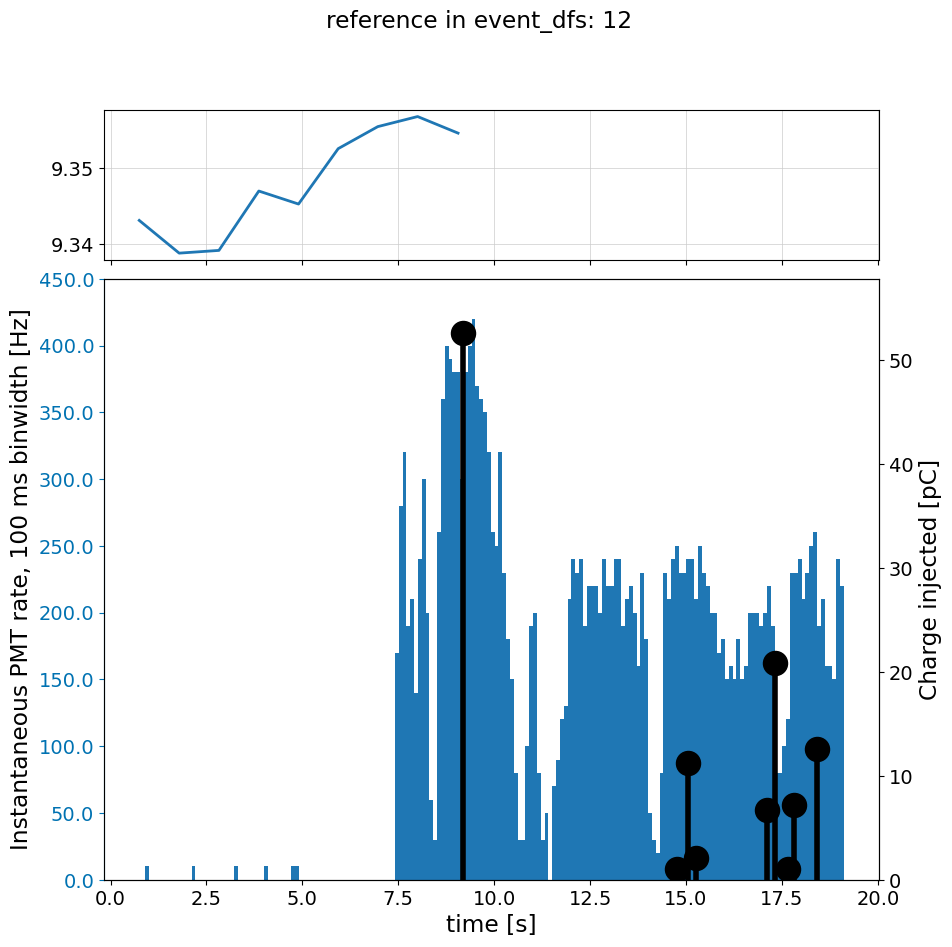

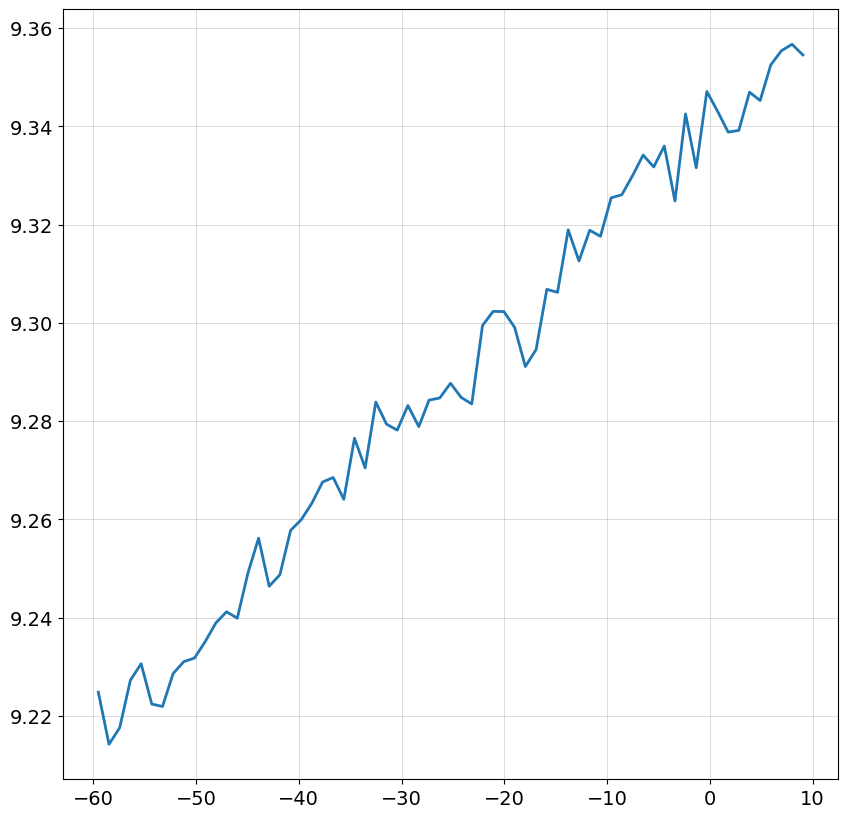

20.041346624000035


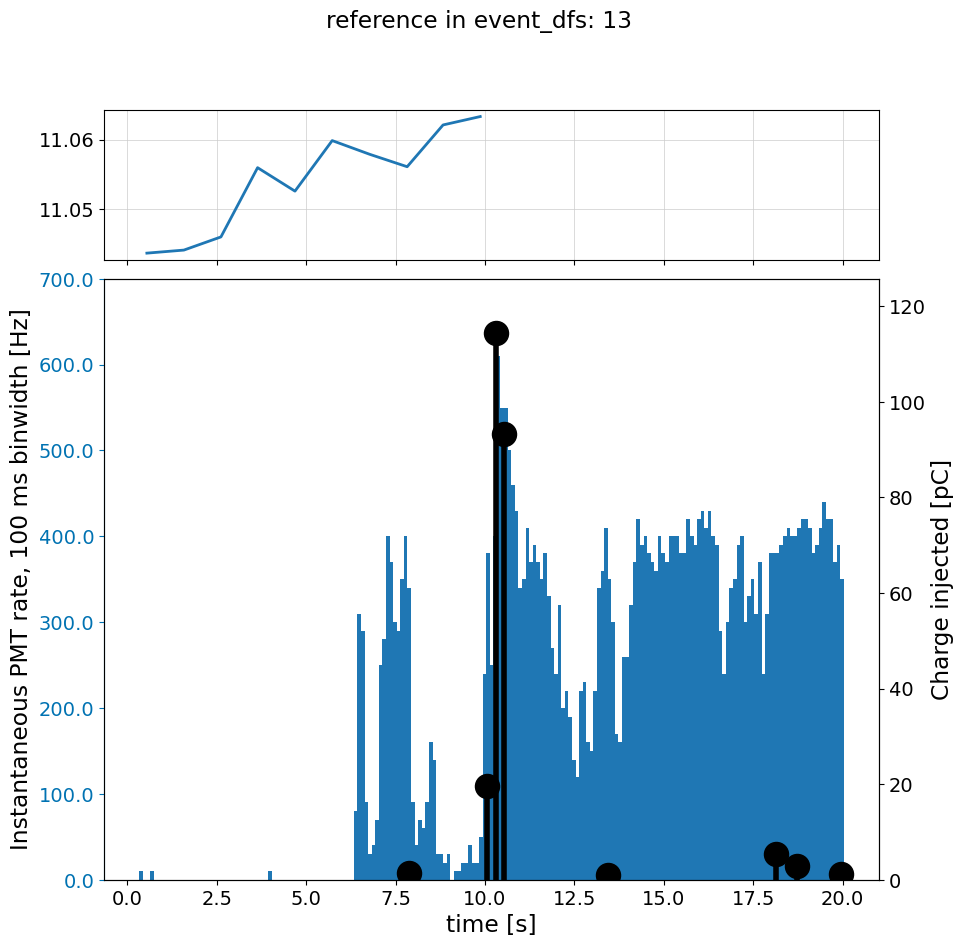

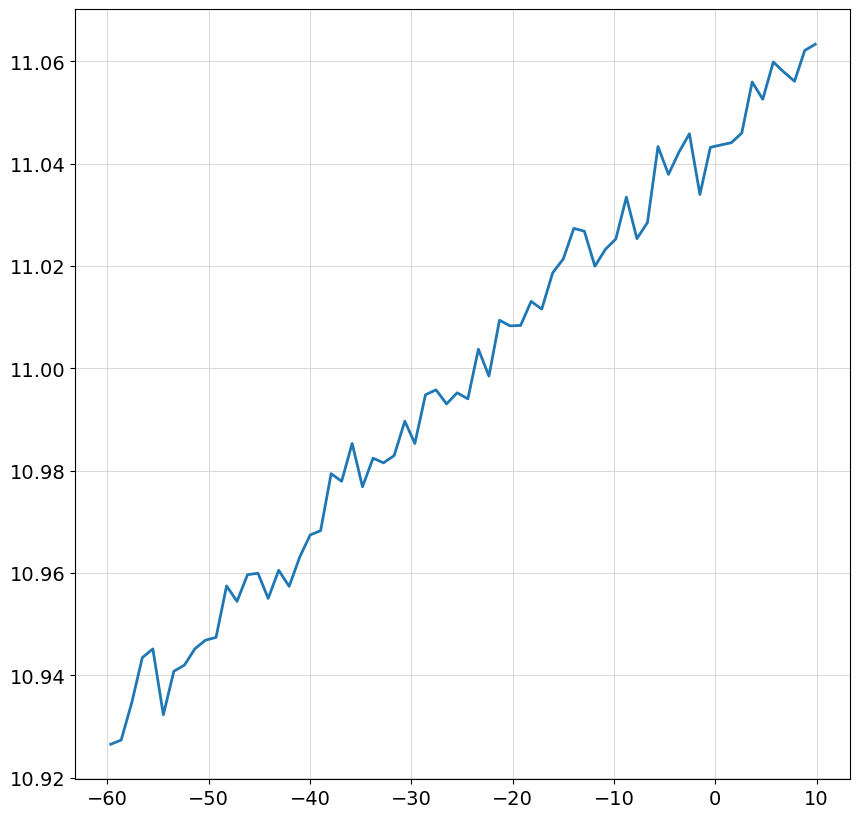

19.64918741600004


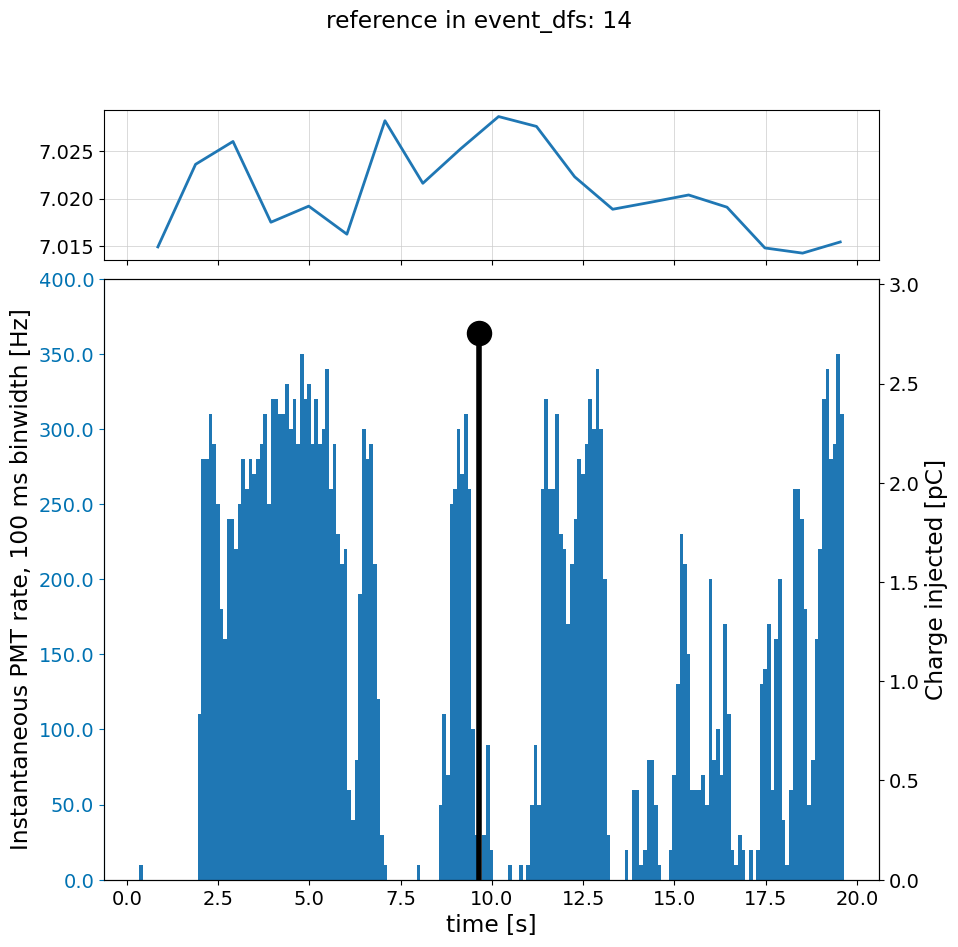

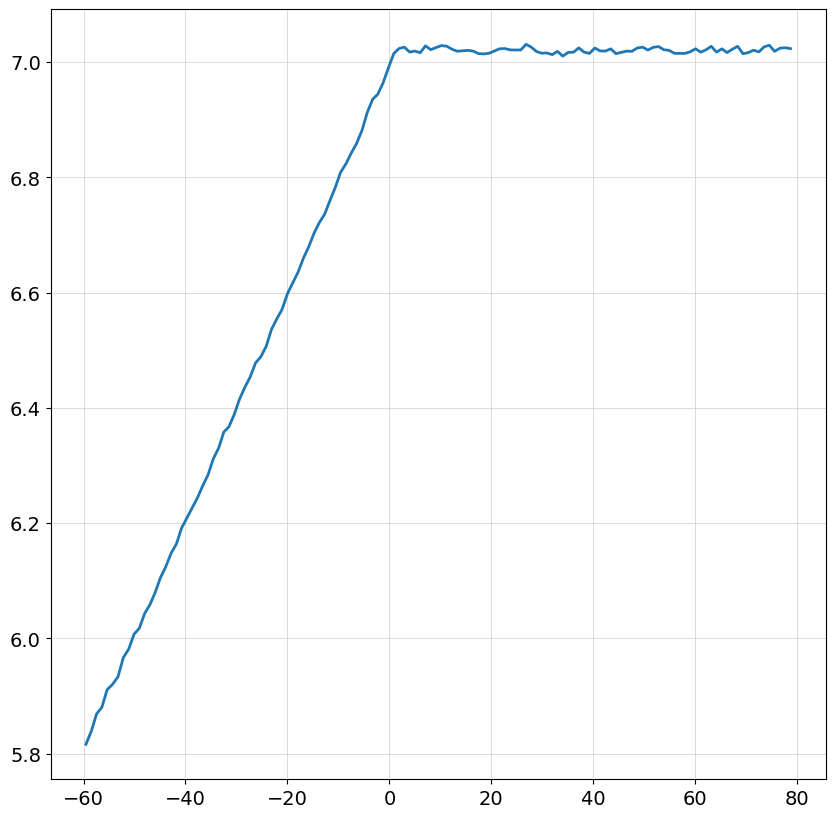

20.63863026400005


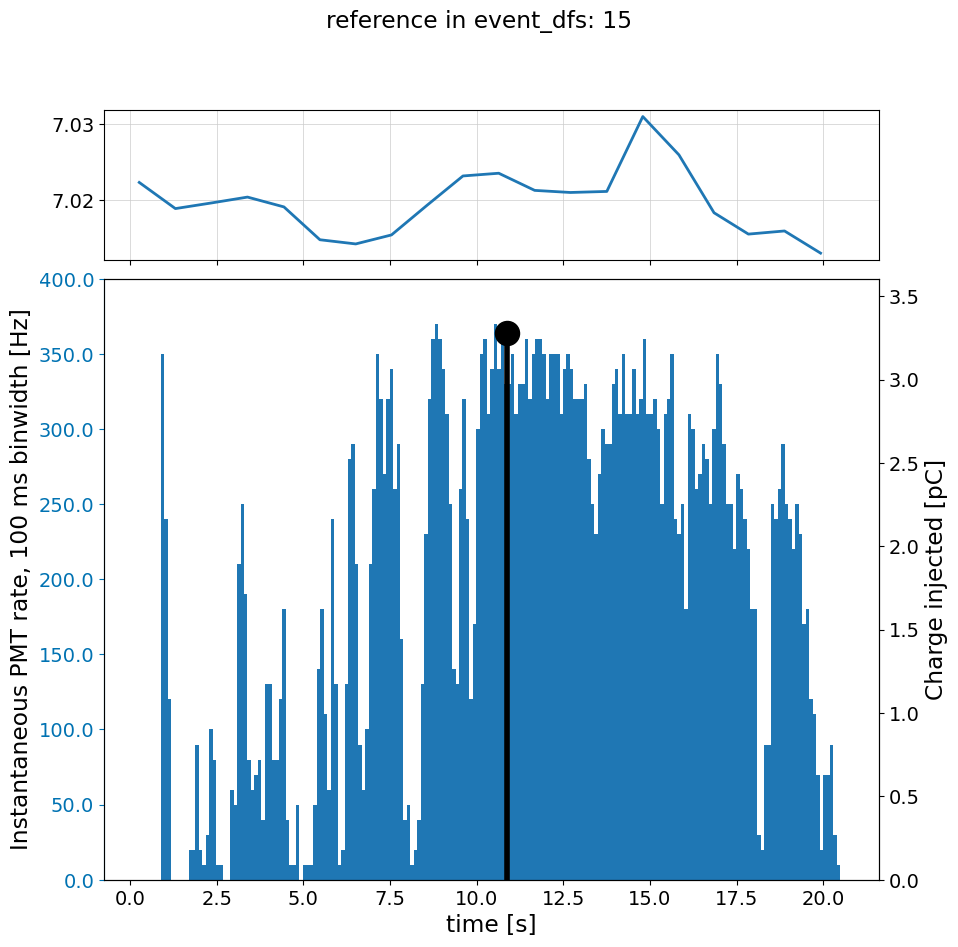

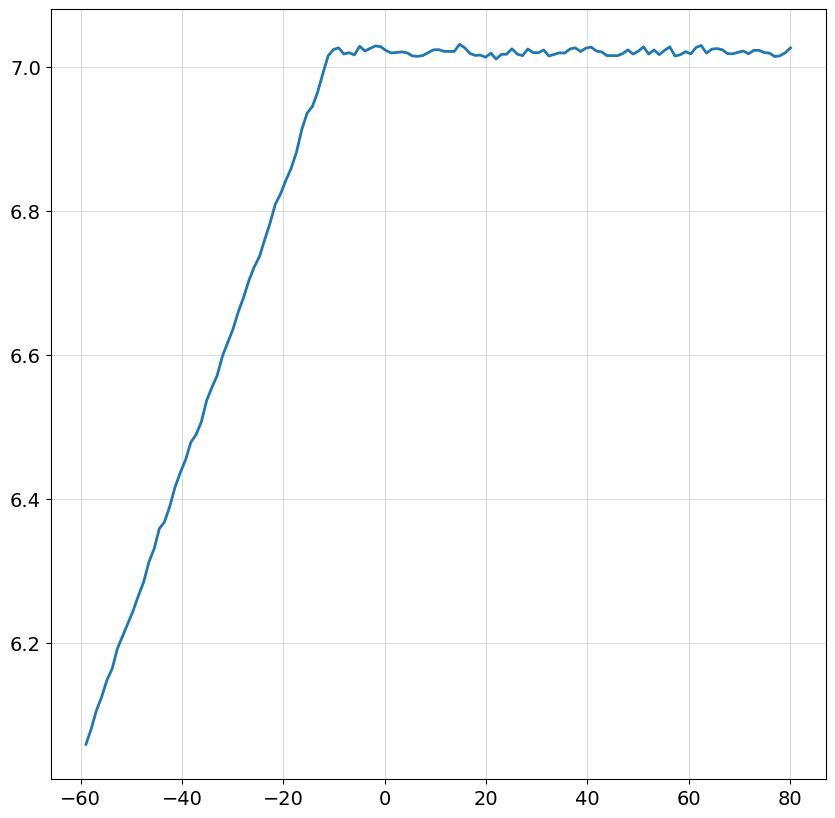

17.950476128000016


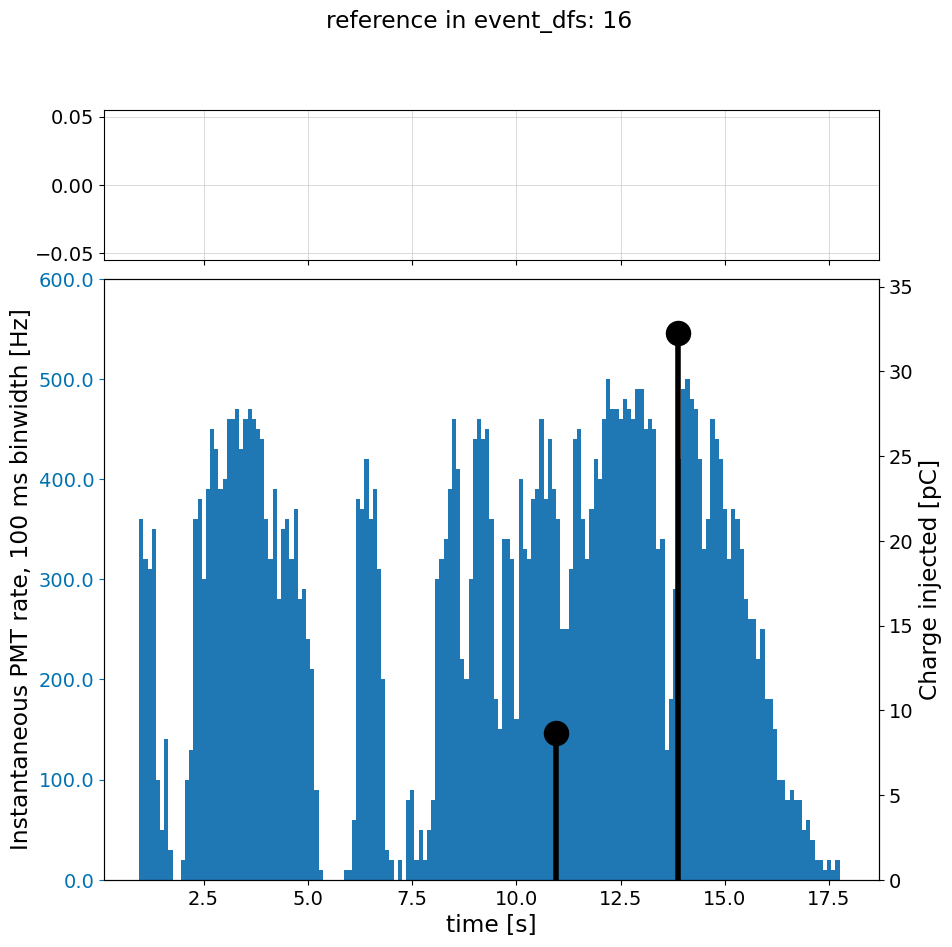

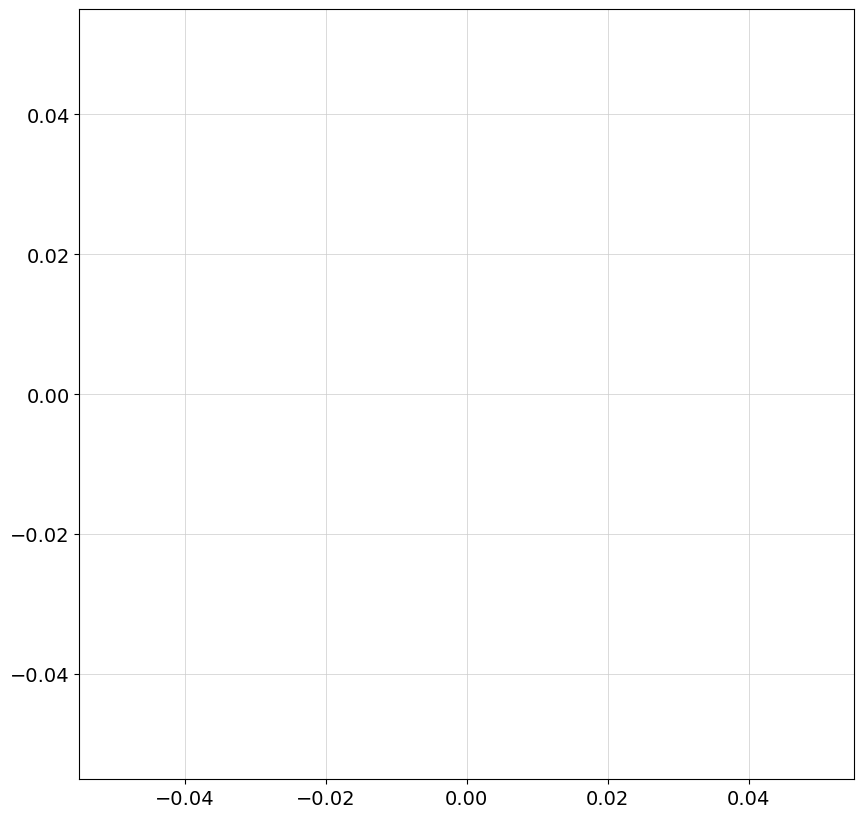

17.233483256000014


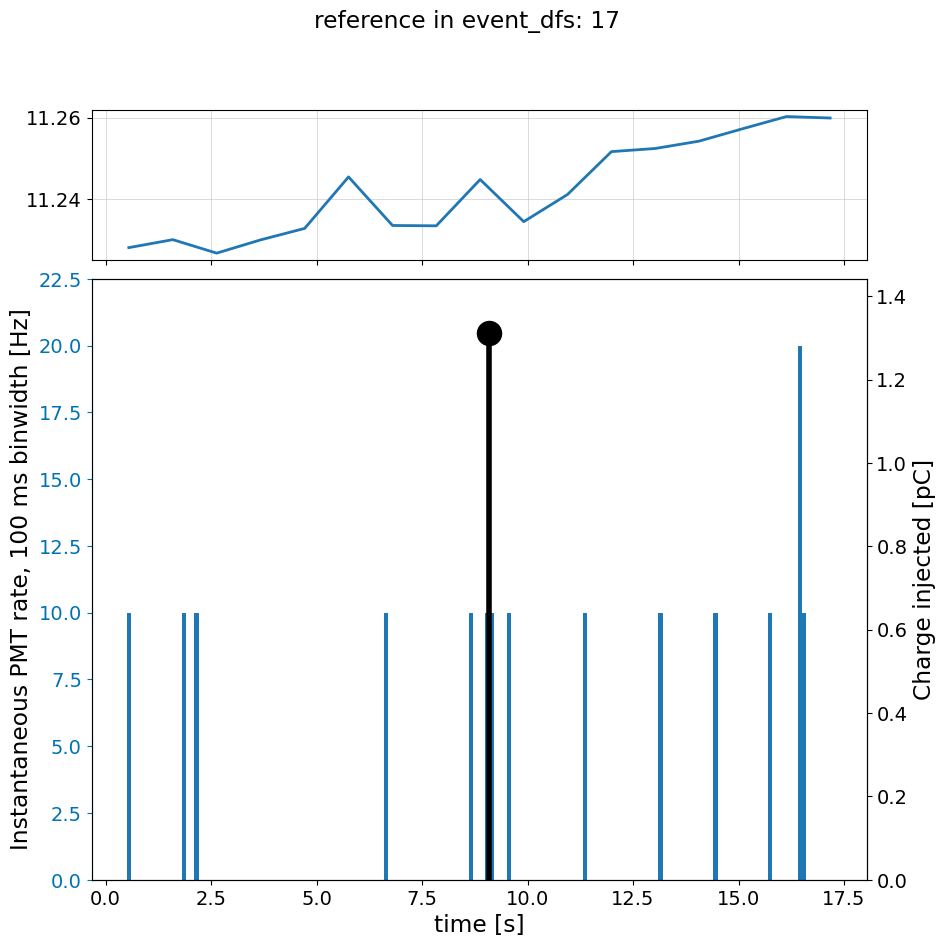

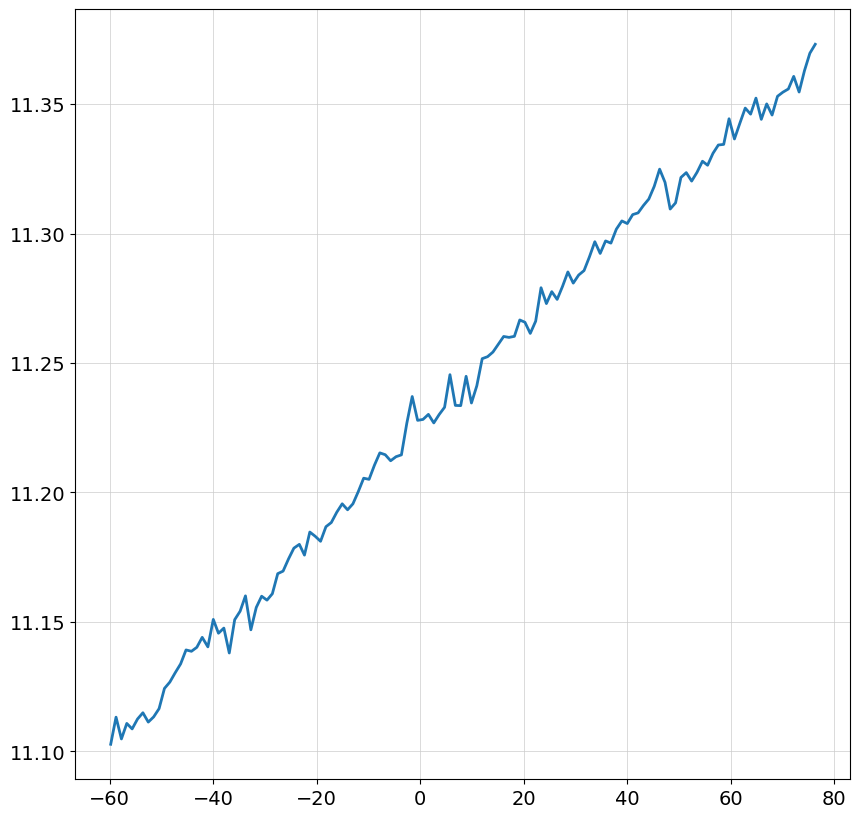

18.53196658400003


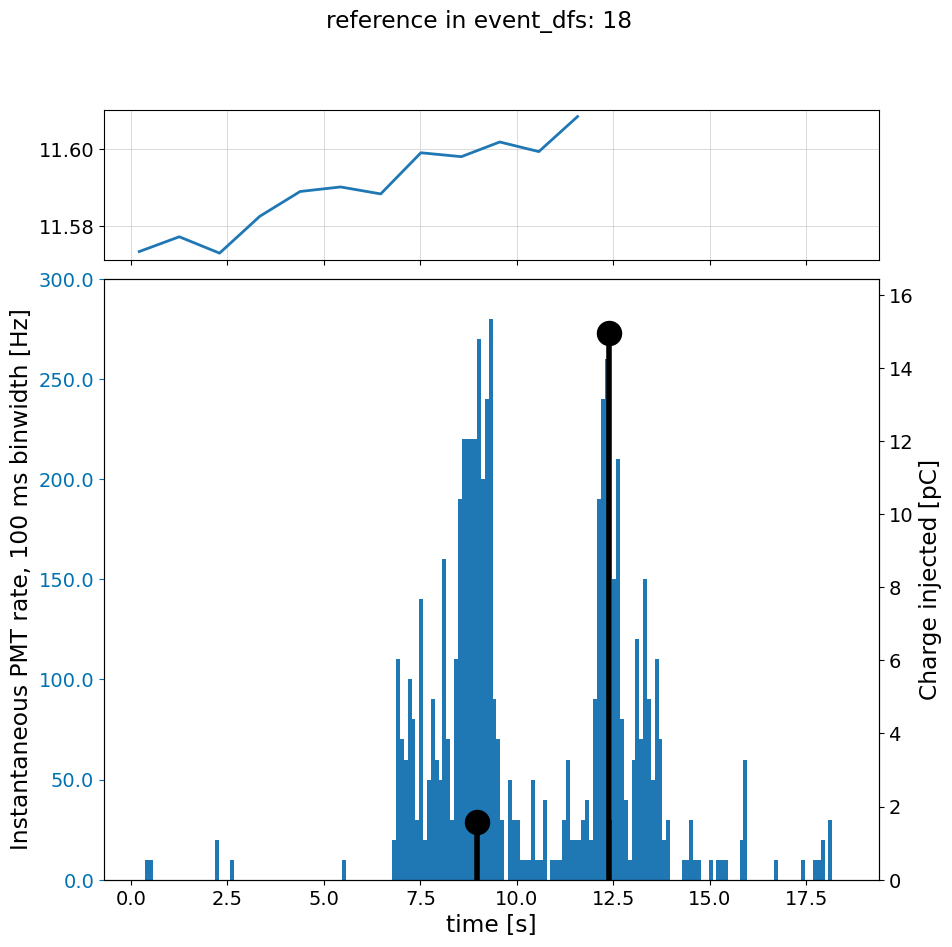

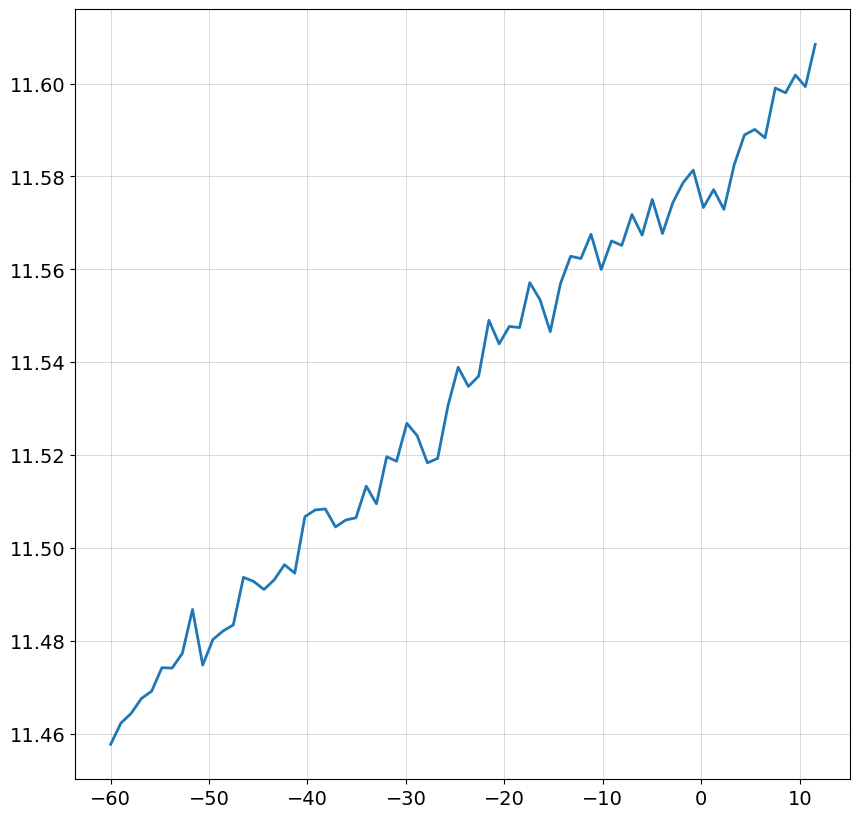

19.25639002400004


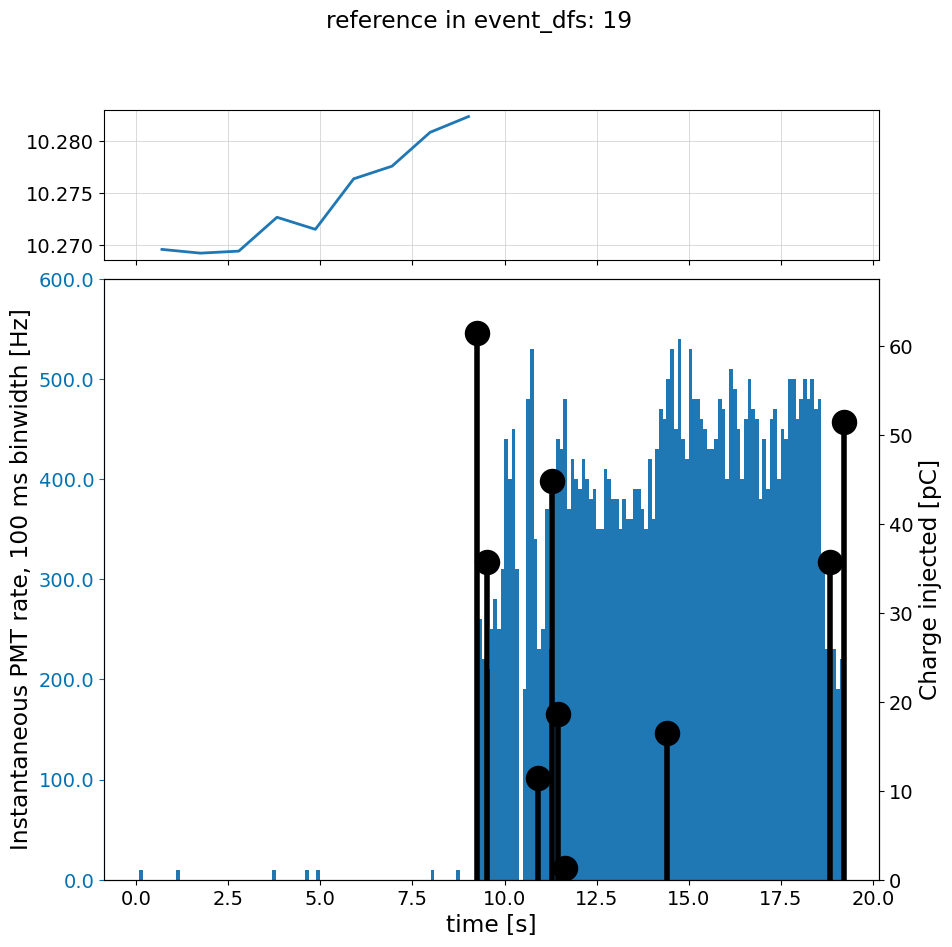

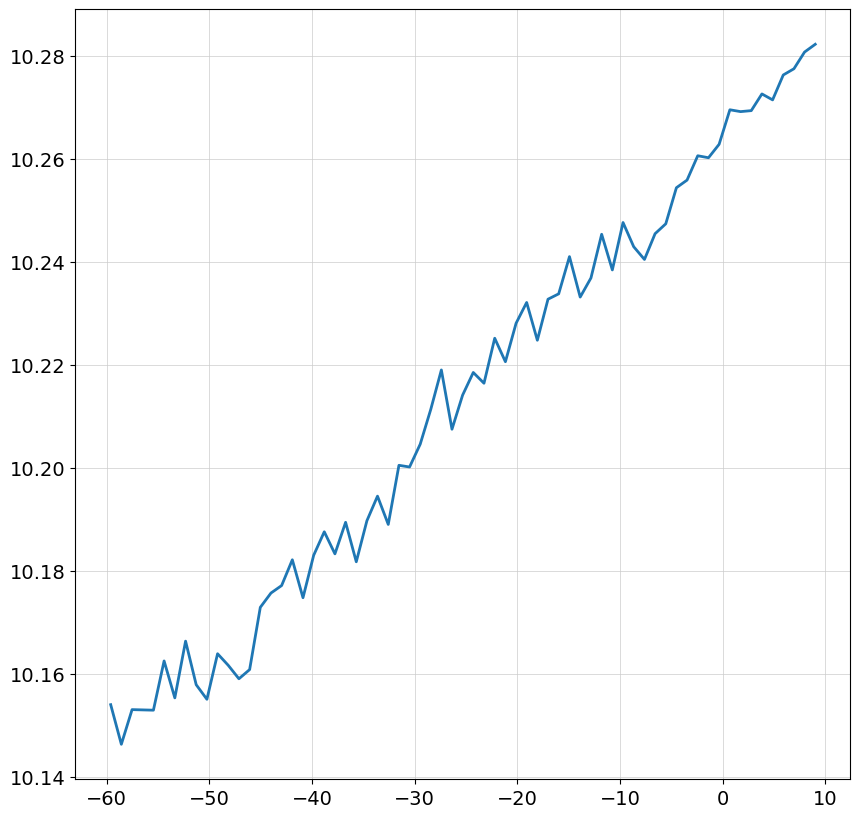

19.906282440000098


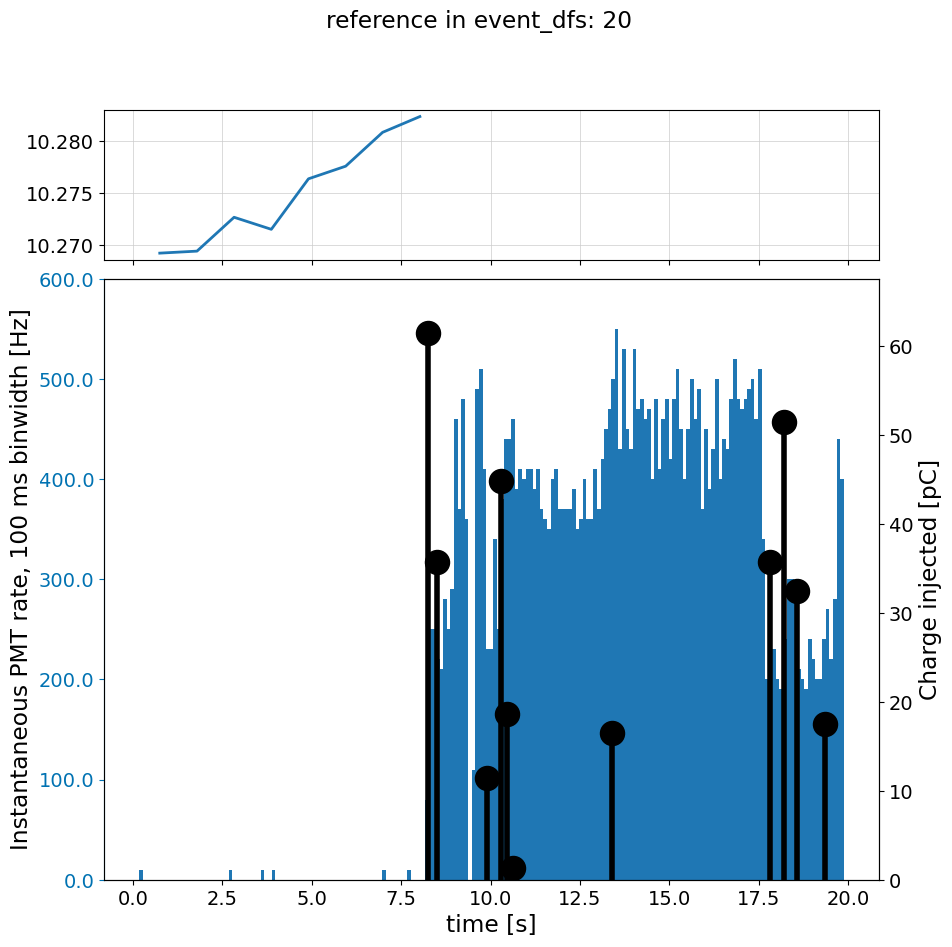

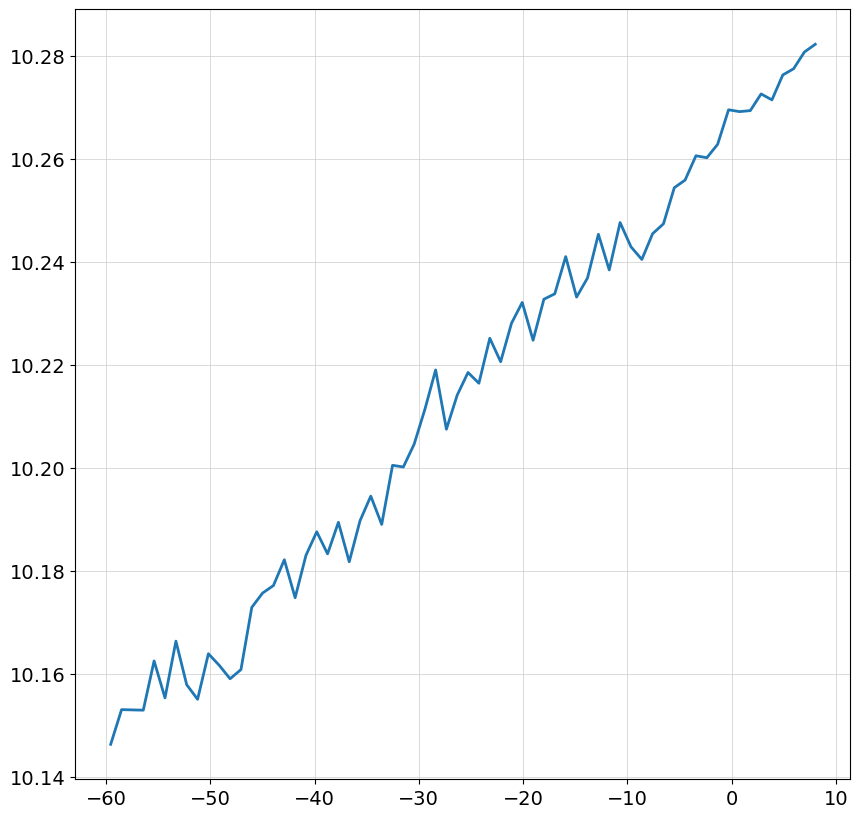

In [5]:
plt.ion()
rate_bin_width = 0.1 #seconds


for j in range(len(event_dfs)):
    if(j > 20): break
    ev = event_dfs[j]
    #select events in light channel that have at least some photons in the PMT waveform 
    mask = ((ev["ch0 amp"] - ev["ch0 baseline"]) > 10) | ((ev["ch1 amp"] - ev["ch1 baseline"]) > 10)
    pmt_events = ev[mask]
    #find the charge events in this df of all events
    mask = (np.abs(ev["ch3 charge"]) > 1)
    charge_events = ev[mask]


    #just used to zero the seconds so that we can add nanosecond info
    t0 = np.min([np.min(pmt_events["ch0 seconds"]), np.min(pmt_events["ch1 seconds"]), np.min(charge_events["ch3 seconds"])])

    #properly time zeroed lists with amplitudes matching in index
    pmt_ts = []
    pmt_amps = []
    pmt_integrals = []
    charge_ts = []
    charge_amps = [] 

    for i, row in pmt_events.iterrows():
        if(np.isnan(row["ch0 amp"]) == False):
            pmt_ts.append((row["ch0 seconds"] - t0) + row["ch0 nanoseconds"]/1e9)

            #it is on the todo list to make these hard-coded integration bound times NOT hard coded... in Dataset.py level 
            #Also, the baseline is not being reconstructed well and biases the integral heavily. I'm going to use a mean of the
            #postbaseline and the baseline here. 
            bl = np.mean([row["ch0 baseline"], np.mean(row["ch0 postbaseline"])])
            ch0_int = row["ch0 afterpulse integral"] - 7.48*bl + row["ch0 trigger integral"] - 0.16*bl
            ch0_amp = row["ch0 amp"] - bl
            #find the ch1 row with the same timestamp. they are split up due to intricacies of the coincidence finding function in AnalysisTools
            sel = pmt_events[(pmt_events["ch1 seconds"] == row["ch0 seconds"]) & (np.abs((pmt_events["ch1 nanoseconds"] - row["ch0 nanoseconds"])) < 1000)]
            if(len(sel.index) == 1):
                sel = sel.iloc[0]
                bl = np.mean([sel["ch1 baseline"], np.mean(sel["ch1 postbaseline"])])
                ch1_int = sel["ch1 afterpulse integral"] - 7.48*bl + sel["ch1 trigger integral"] - 0.16*bl
                ch1_amp = sel["ch1 amp"] - bl
                pmt_integrals.append(ch0_int + ch1_int)
                pmt_amps.append(ch1_amp + ch0_amp)
            else:
                pmt_integrals.append(ch0_int)
                pmt_amps.append(ch0_amp)

    for i, row in charge_events.iterrows():
        if(np.isnan(row["ch3 charge"]) == False):
            charge_ts.append((row["ch3 seconds"] - t0) + row["ch3 nanoseconds"]/1e9)
            charge_amps.append(np.abs(row["ch3 charge"]))
            
    

    time_bounds = [np.min([np.min(pmt_ts), np.min(charge_ts)]), np.max([np.max(pmt_ts), np.max(charge_ts)])]
    bins = np.arange(time_bounds[0], time_bounds[1], rate_bin_width)
    print(time_bounds[1])
    fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [1, 4], 'hspace': 0.05}, sharex=True)
    ax_amp = ax_bottom.twinx()
    ax_bottom.hist(pmt_ts, bins=bins, label="PMT rate")
    for i in range(len(charge_ts)):
        ax_amp.plot([charge_ts[i], charge_ts[i]], [0, charge_amps[i]], color="k", linewidth=4)
        ax_amp.scatter([charge_ts[i]], [charge_amps[i]], color="k", s=300)
    
    filtered_time = ana.ramp_data[(ana.ramp_data['t']>= t0) & (ana.ramp_data['t']<= t0 + time_bounds[1])]
    filtered_time = filtered_time.copy()
    filtered_time['t'] = filtered_time['t'] - t0
    
    ax_top.plot(filtered_time['t'],filtered_time['v_mon'])

    ax_amp.set_ylabel("Charge injected [pC]")
    ax_bottom.spines['left'].set_color('#0072B2')
    ax_bottom.tick_params(axis='y', colors='#0072B2')
    #this block of code converts the histogram to [Hz] instead of counts
    y_vals = ax_bottom.get_yticks()
    ax_bottom.set_yticks(y_vals)
    ax_bottom.set_yticklabels(['{:0.1f}'.format(_ / rate_bin_width) for _ in y_vals])
    ax_bottom.set_ylabel("Instantaneous PMT rate, {:.0f} ms binwidth [Hz]".format(1000*rate_bin_width))
    ax_bottom.set_xlabel("time [s]")
    ax_bottom.grid(False)
    ax_amp.grid(False)
    ax_amp.set_ylim([0, np.max(charge_amps)*1.1])
    fig.suptitle("reference in event_dfs: {:d}".format(j))
    #ax_bottom.set_title("reference in event_dfs: {:d}".format(j))
    
    plt.show()
    
    fig, ax = plt.subplots()
    ana.load_hv_textfiles()
    filtered_time = ana.ramp_data[(ana.ramp_data['t']>= t0-60) & (ana.ramp_data['t']<= t0 + time_bounds[1]+60)]
    filtered_time = filtered_time.copy()
    filtered_time['t'] = filtered_time['t'] - t0    
    ax.plot(filtered_time['t'],filtered_time['v_mon'])
    plt.show()

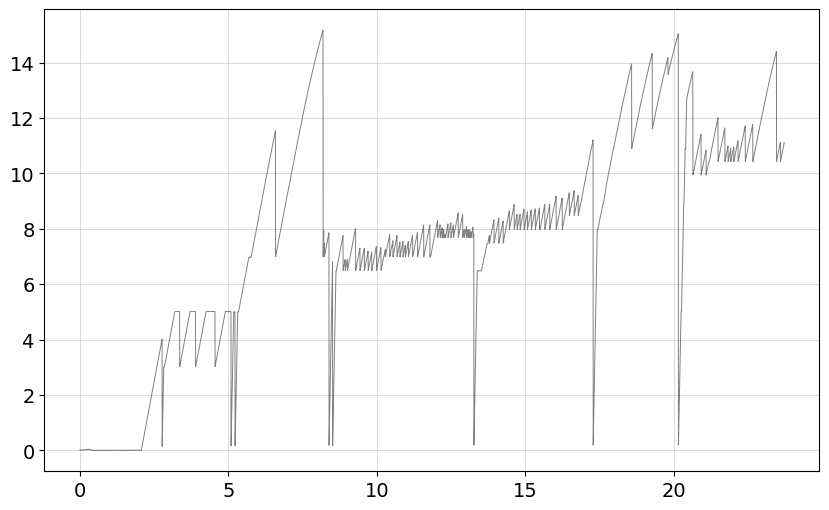

/Users/linsi/Documents/stanford/HV/ad2-data-processing/AnalysisTools/AnalysisTools.py:127: UserWarning: genfromtxt: Empty input file: "/Users/linsi/Documents/stanford/HV/data/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


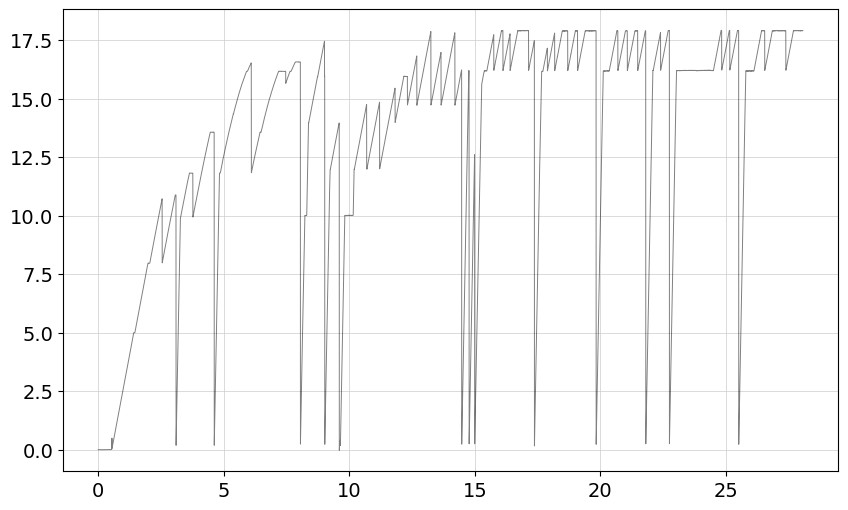

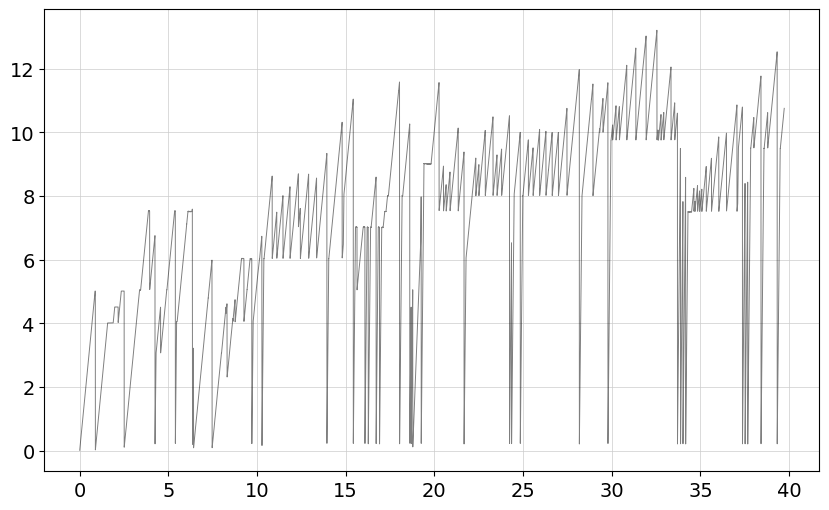

In [7]:
for i, run in enumerate([7,8,9]):
    fig, ax = plt.subplots()
    #ax.set_ylim([-1, 19]) #fixed axis for all
    #ax.set_xlim([-1, 42])
    
    ana = anas[run]
    d = ana.df
    d = d[~d["ch3 charge"].isna()]
    ana.load_hv_textfiles()
    ana.identify_ramps(ref='v_mon')
    tdmap = ana.time_duration_map
    ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color='k', linewidth=0.7, alpha=0.5)
    
    plt.show()

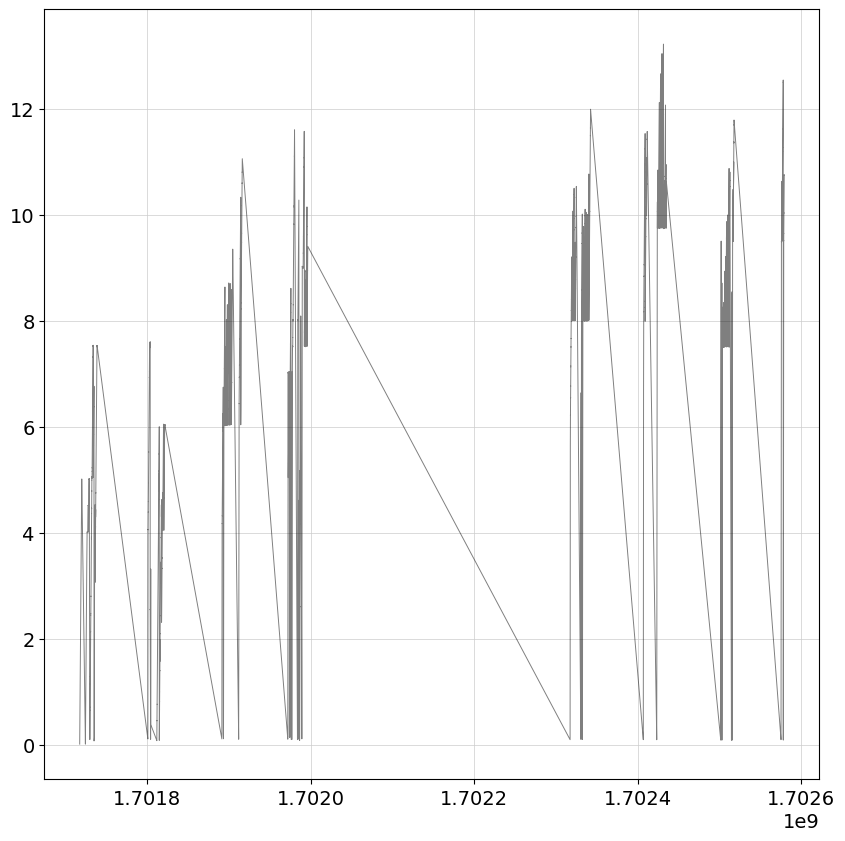

In [14]:
fig, ax = plt.subplots()
ana = anas[9]
ana.load_hv_textfiles()
ax.plot(ana.ramp_data['t'], ana.ramp_data['v_mon'], color='k', linewidth=0.7, alpha=0.5)
plt.show()